In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
# Set your repo major name here
repo_name = 'fga-eps-mds-2022.2-EuPescador-'

# Add your repos here
repos_language = {
    'User': 'ts',
    'FishWiki': 'ts',
    'FishLog': 'ts',
    'Web': 'ts',
    'Mobile': 'ts',
}

In [5]:
# Maybe you should change this path to your own path

sonar_files = glob('./analytics-raw-data/*.json')

In [6]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

In [8]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

In [9]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

In [10]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(300000)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

In [11]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)
        base_name = base_name.replace(".", "-", 1)
        base_name = base_name.replace("", "-")
       

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)
    
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [12]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2022-2-EuPescador-FishLog',
       'fga-eps-mds-2022-2-EuPescador-FishWiki',
       'fga-eps-mds-2022-2-EuPescador-Mobile',
       'fga-eps-mds-2022-2-EuPescador-User',
       'fga-eps-mds-2022-2-EuPescador-Web'], dtype=object)

In [13]:
repos_dataframes = []

for repo in repos_language.keys():
    temp_repo_name = (repo_name+repo).replace(".", "-")
    dataframe = file_component_df[file_component_df['repository'] == temp_repo_name]
    repos_dataframes.append({'name': repo, 'df': dataframe})

In [14]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

In [15]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

In [16]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

In [17]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

In [18]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

In [19]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

In [20]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

In [21]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m3_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [22]:
# You will need to create each metrics dataframe for each repository, in this case, we have 4 repositories

metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

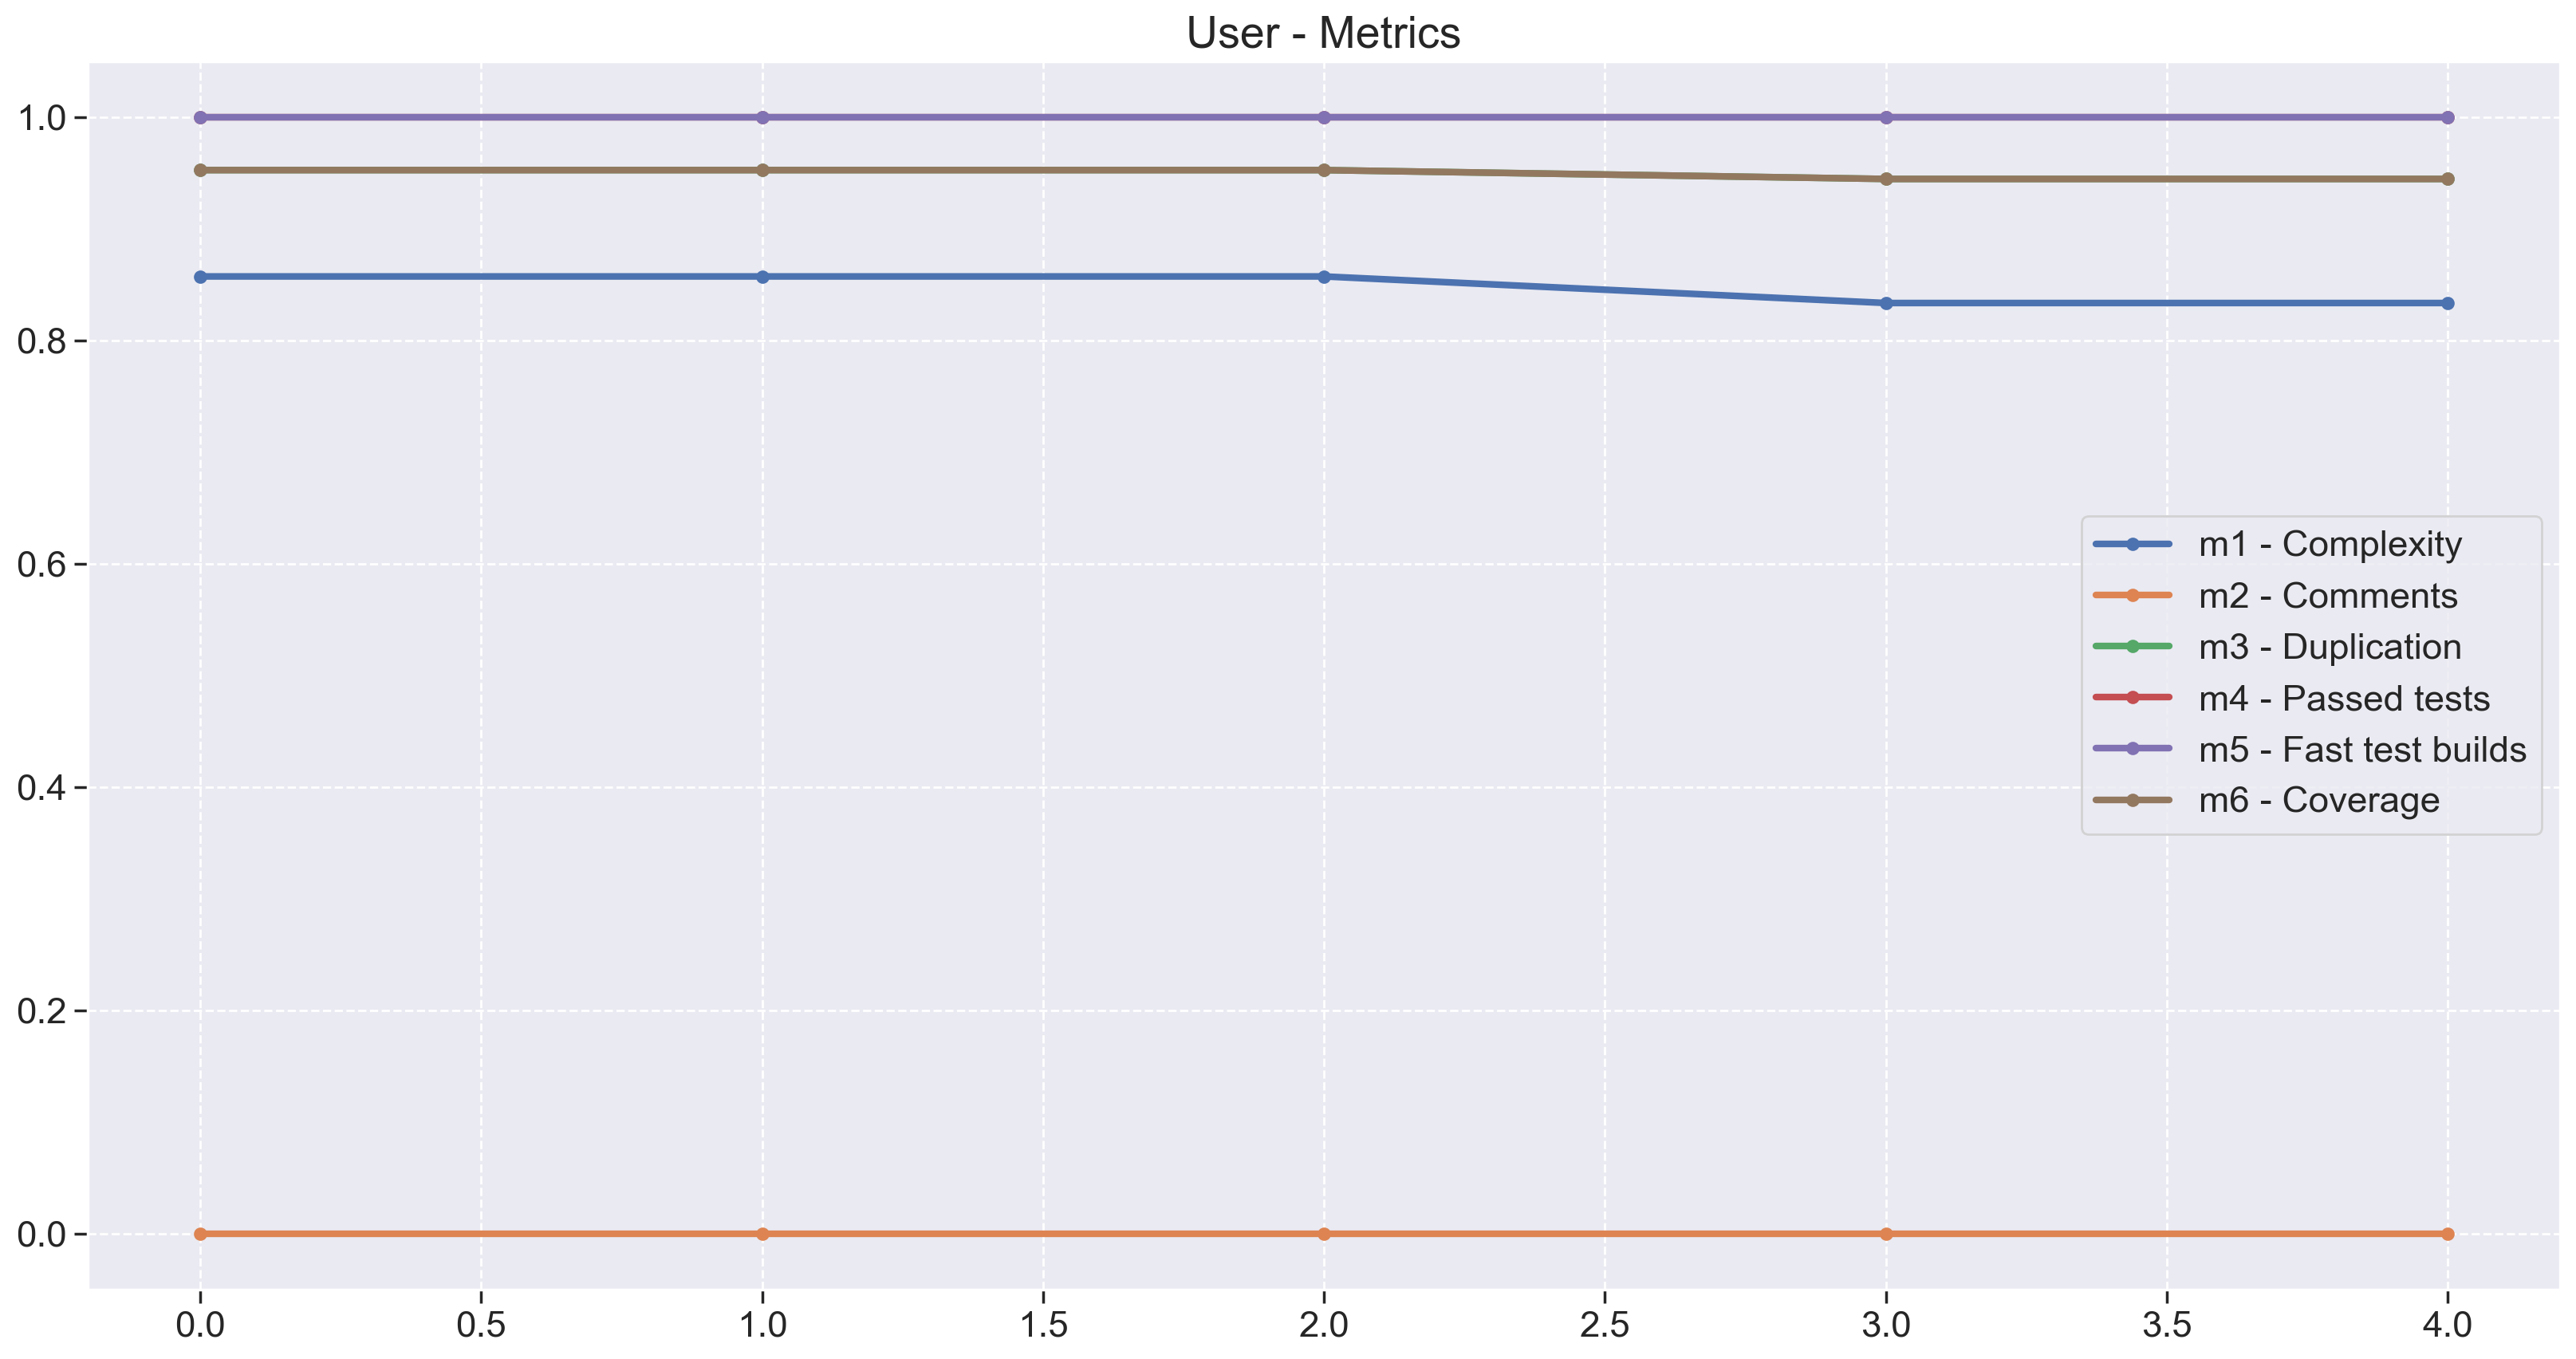

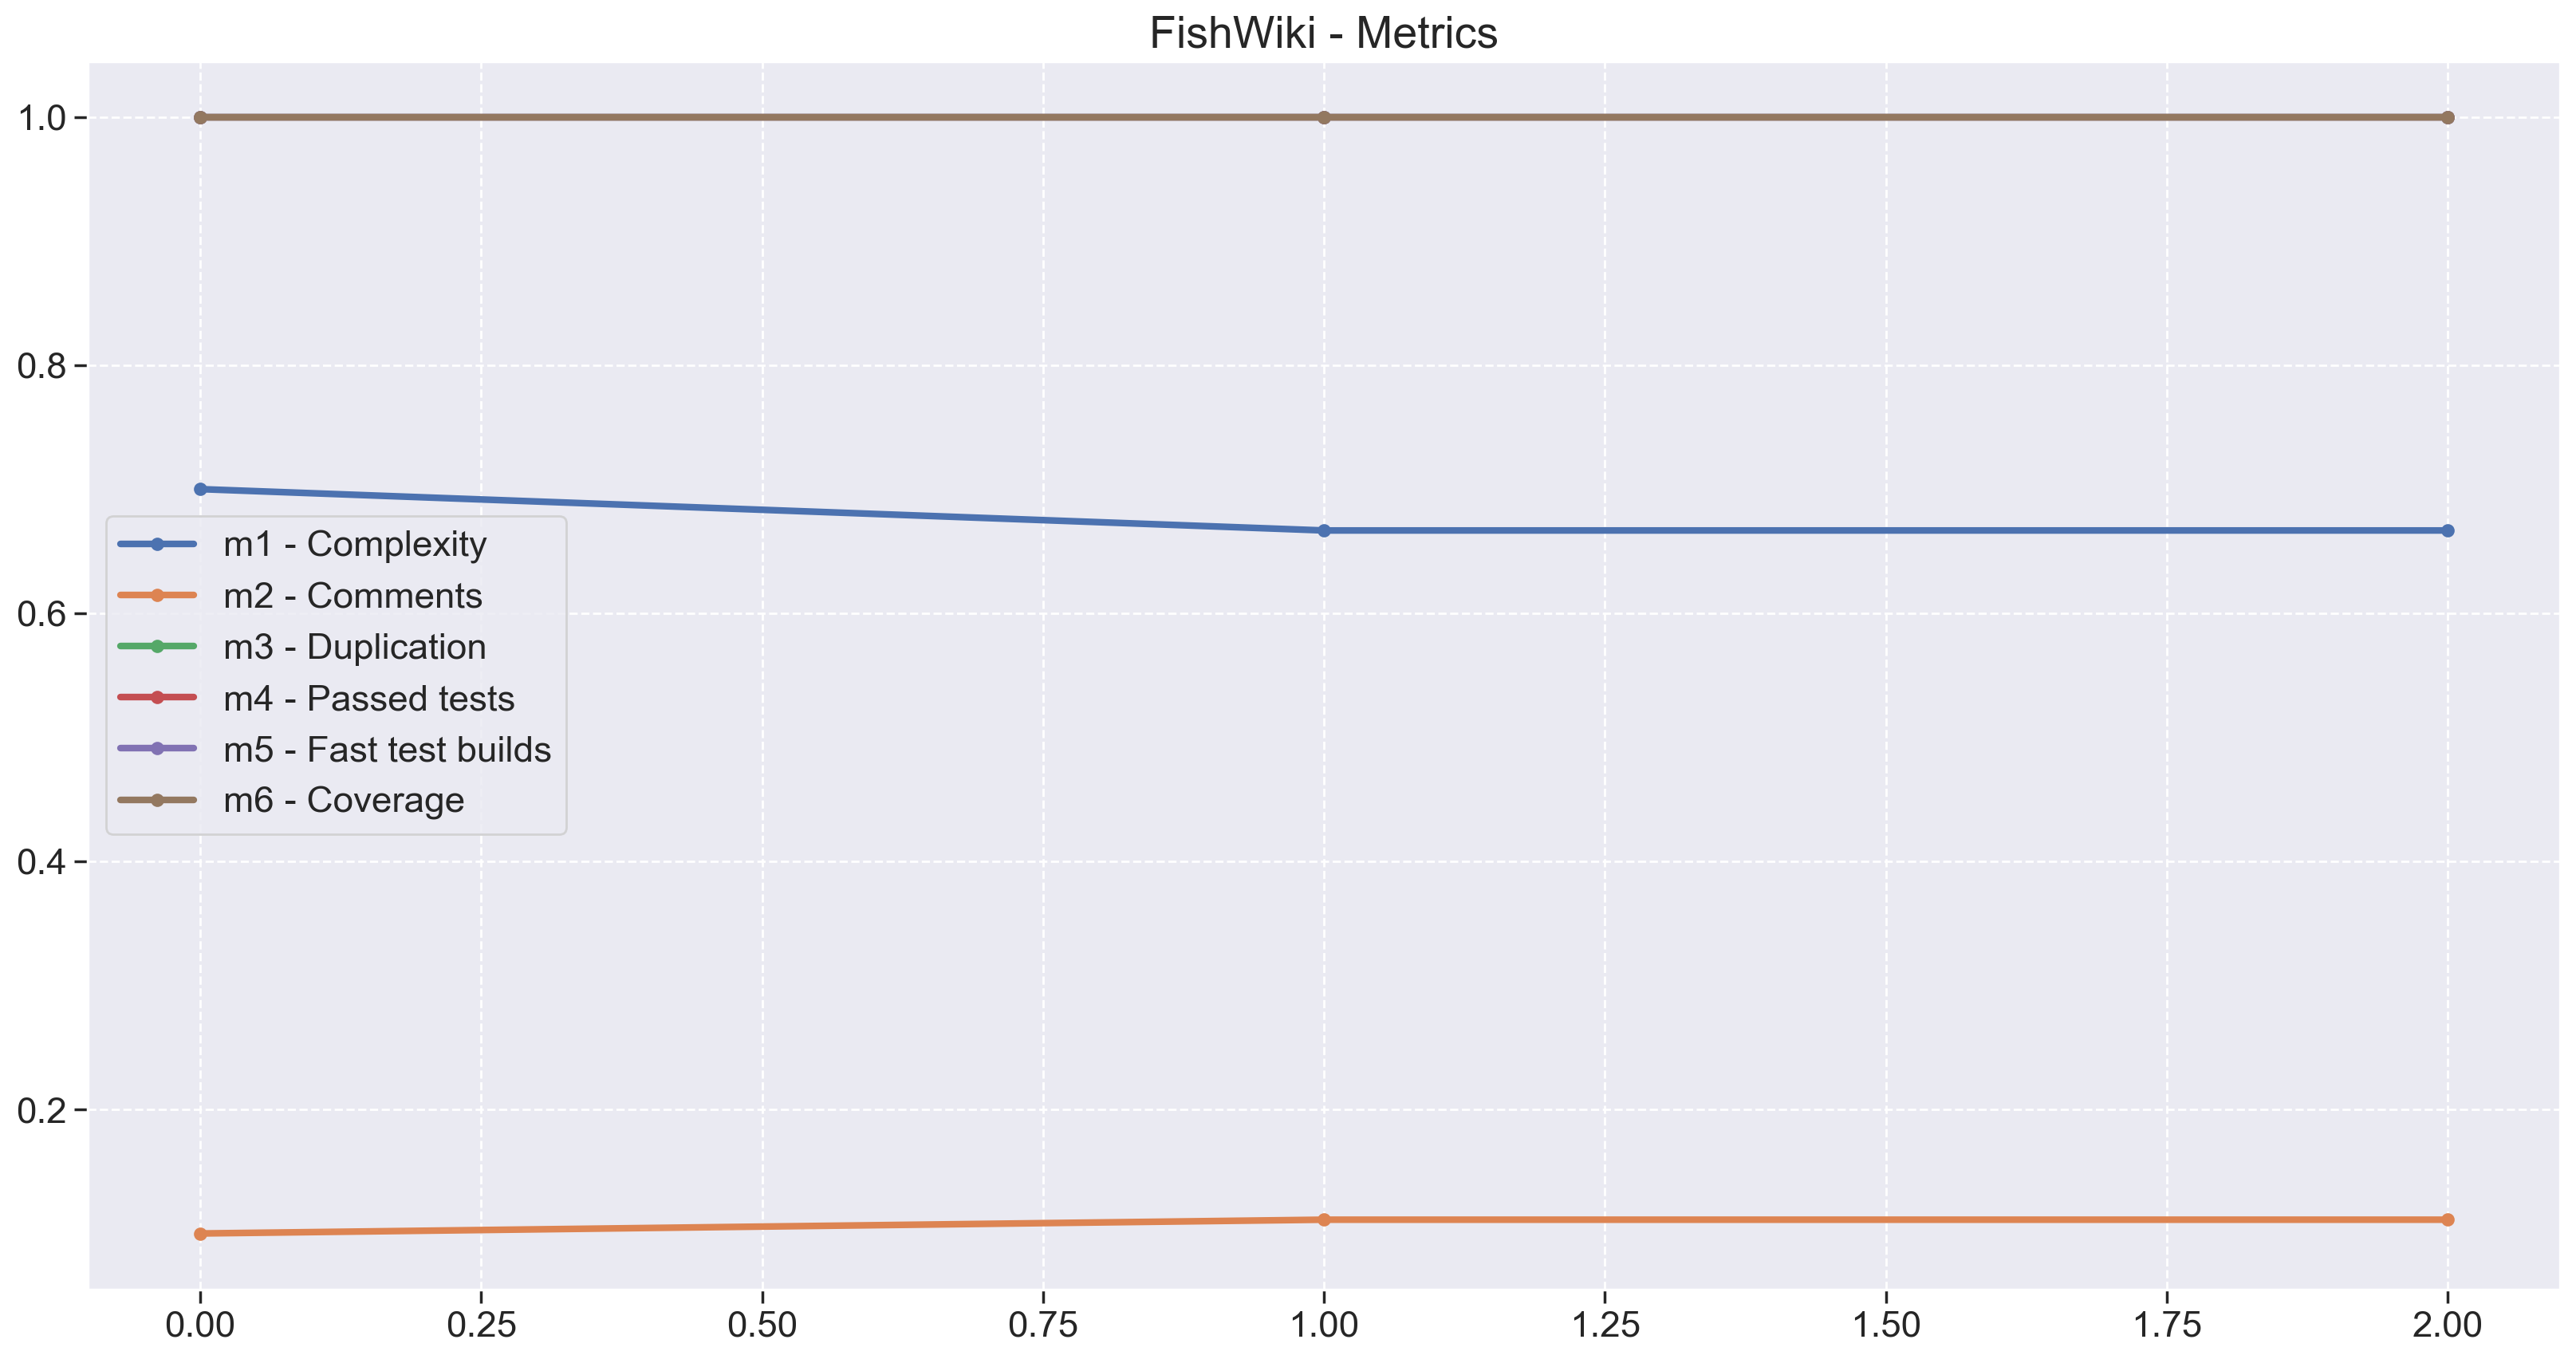

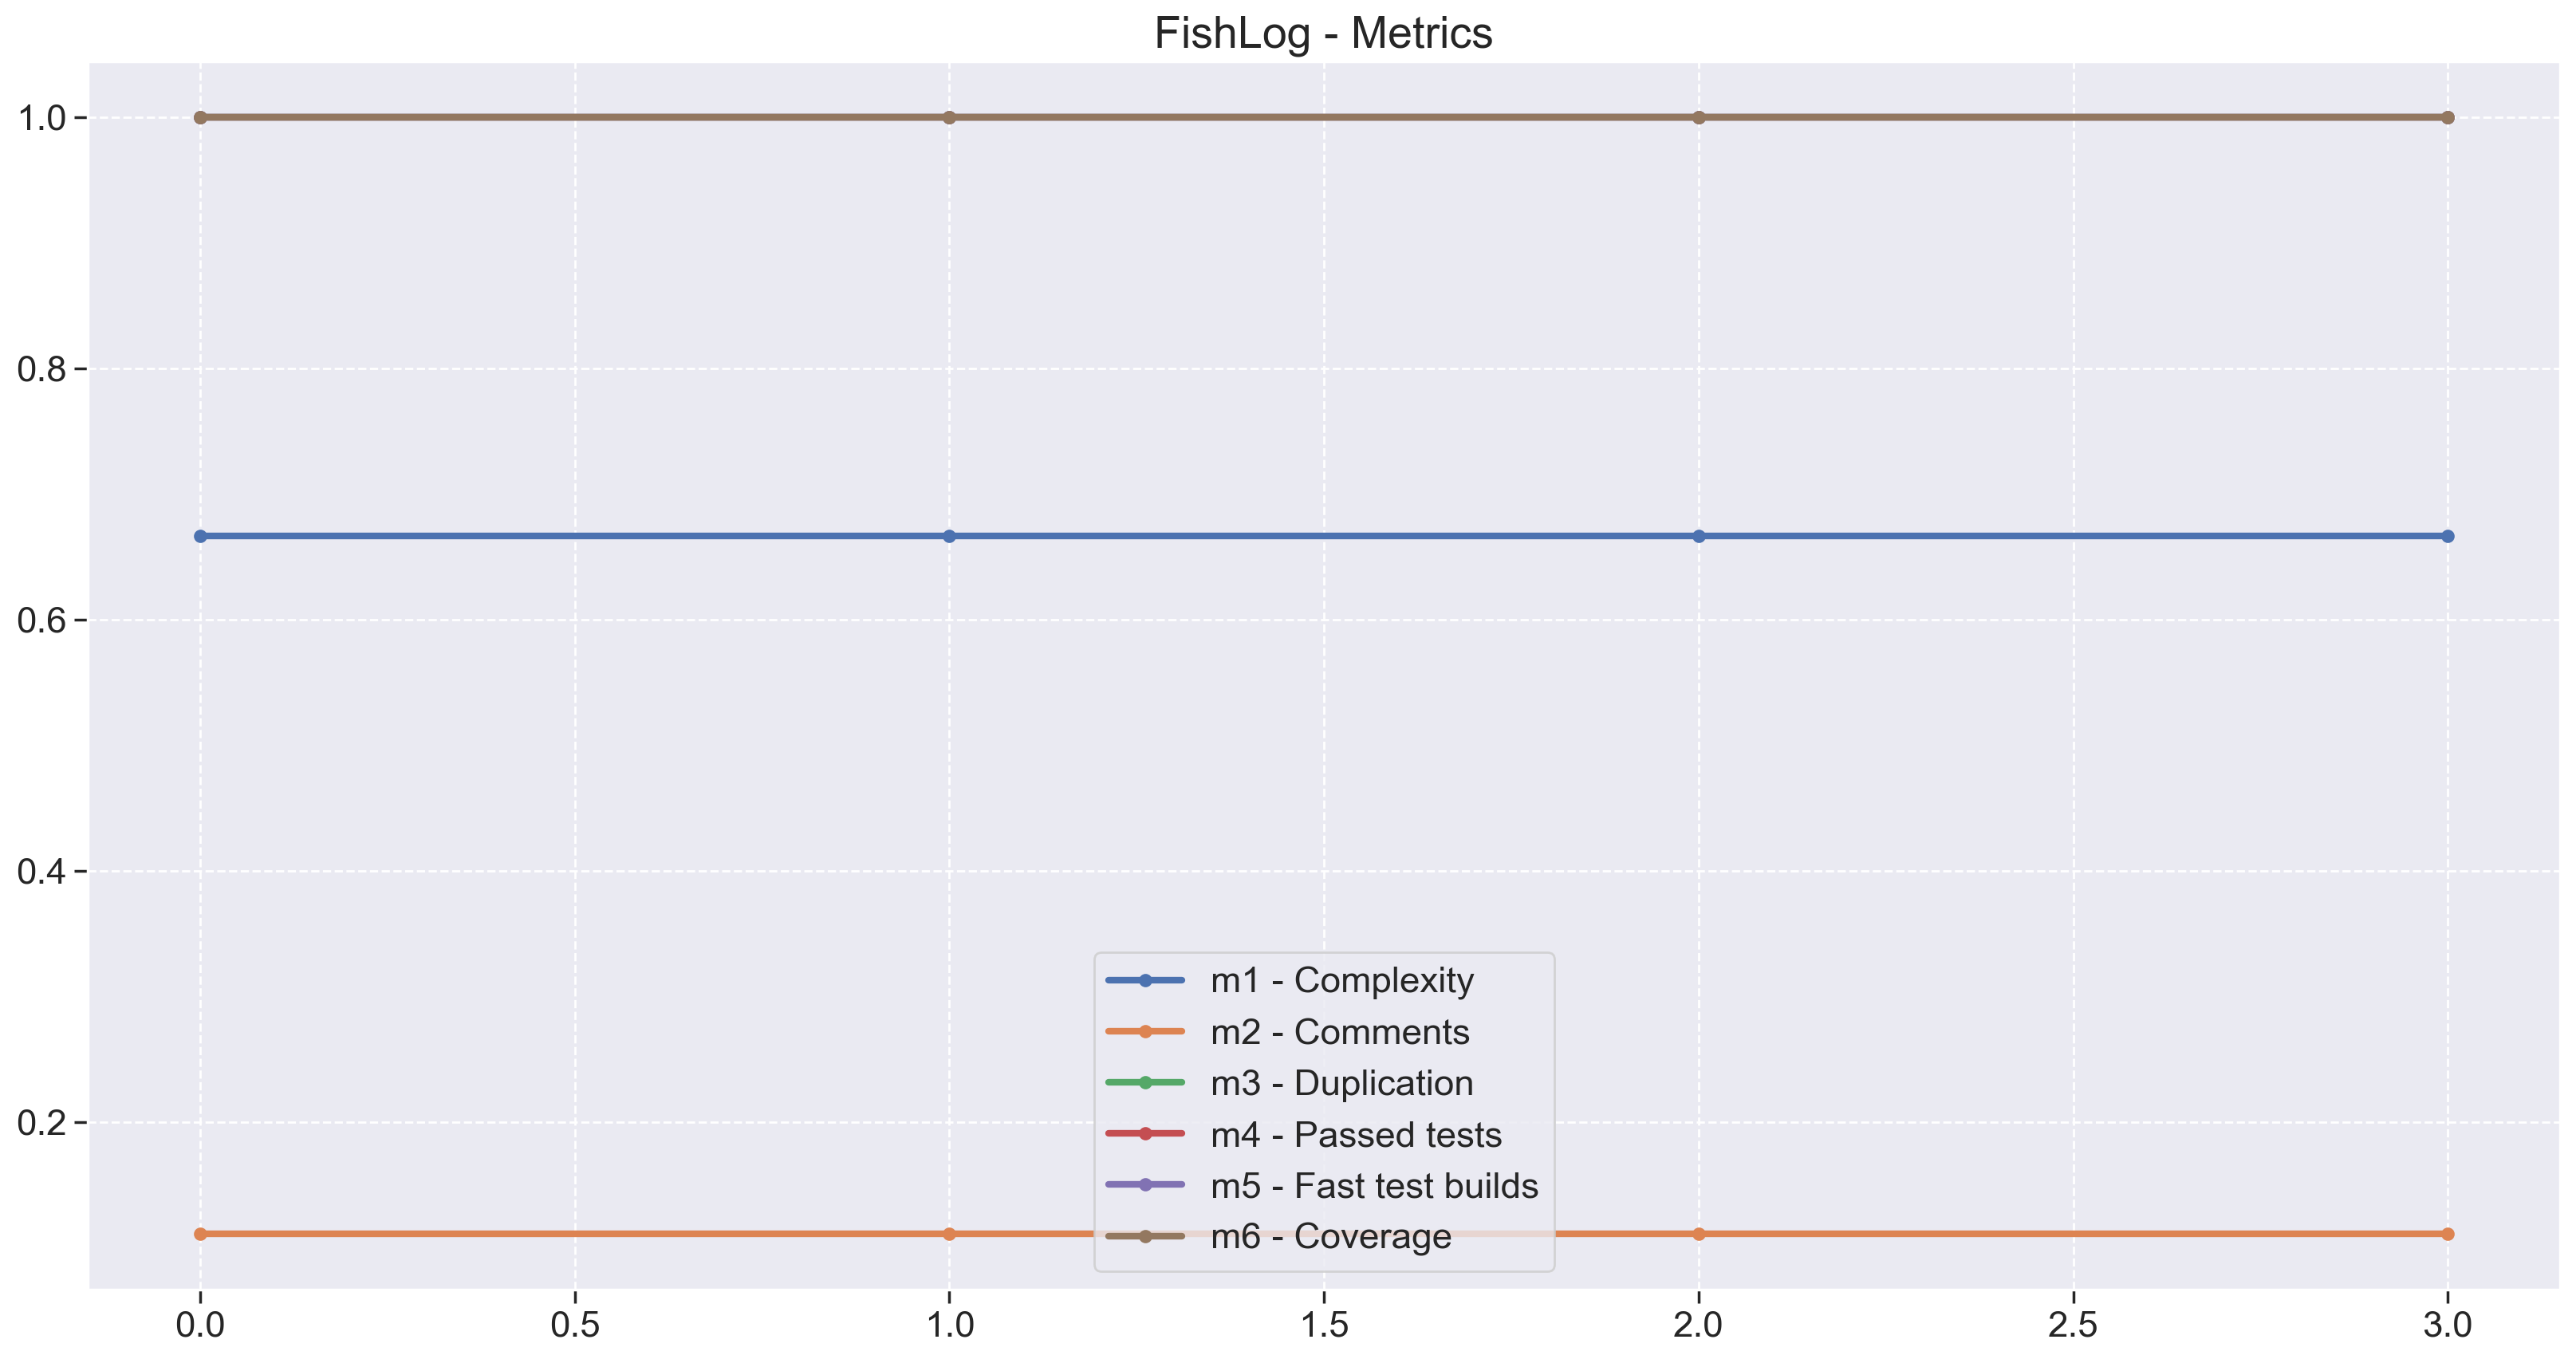

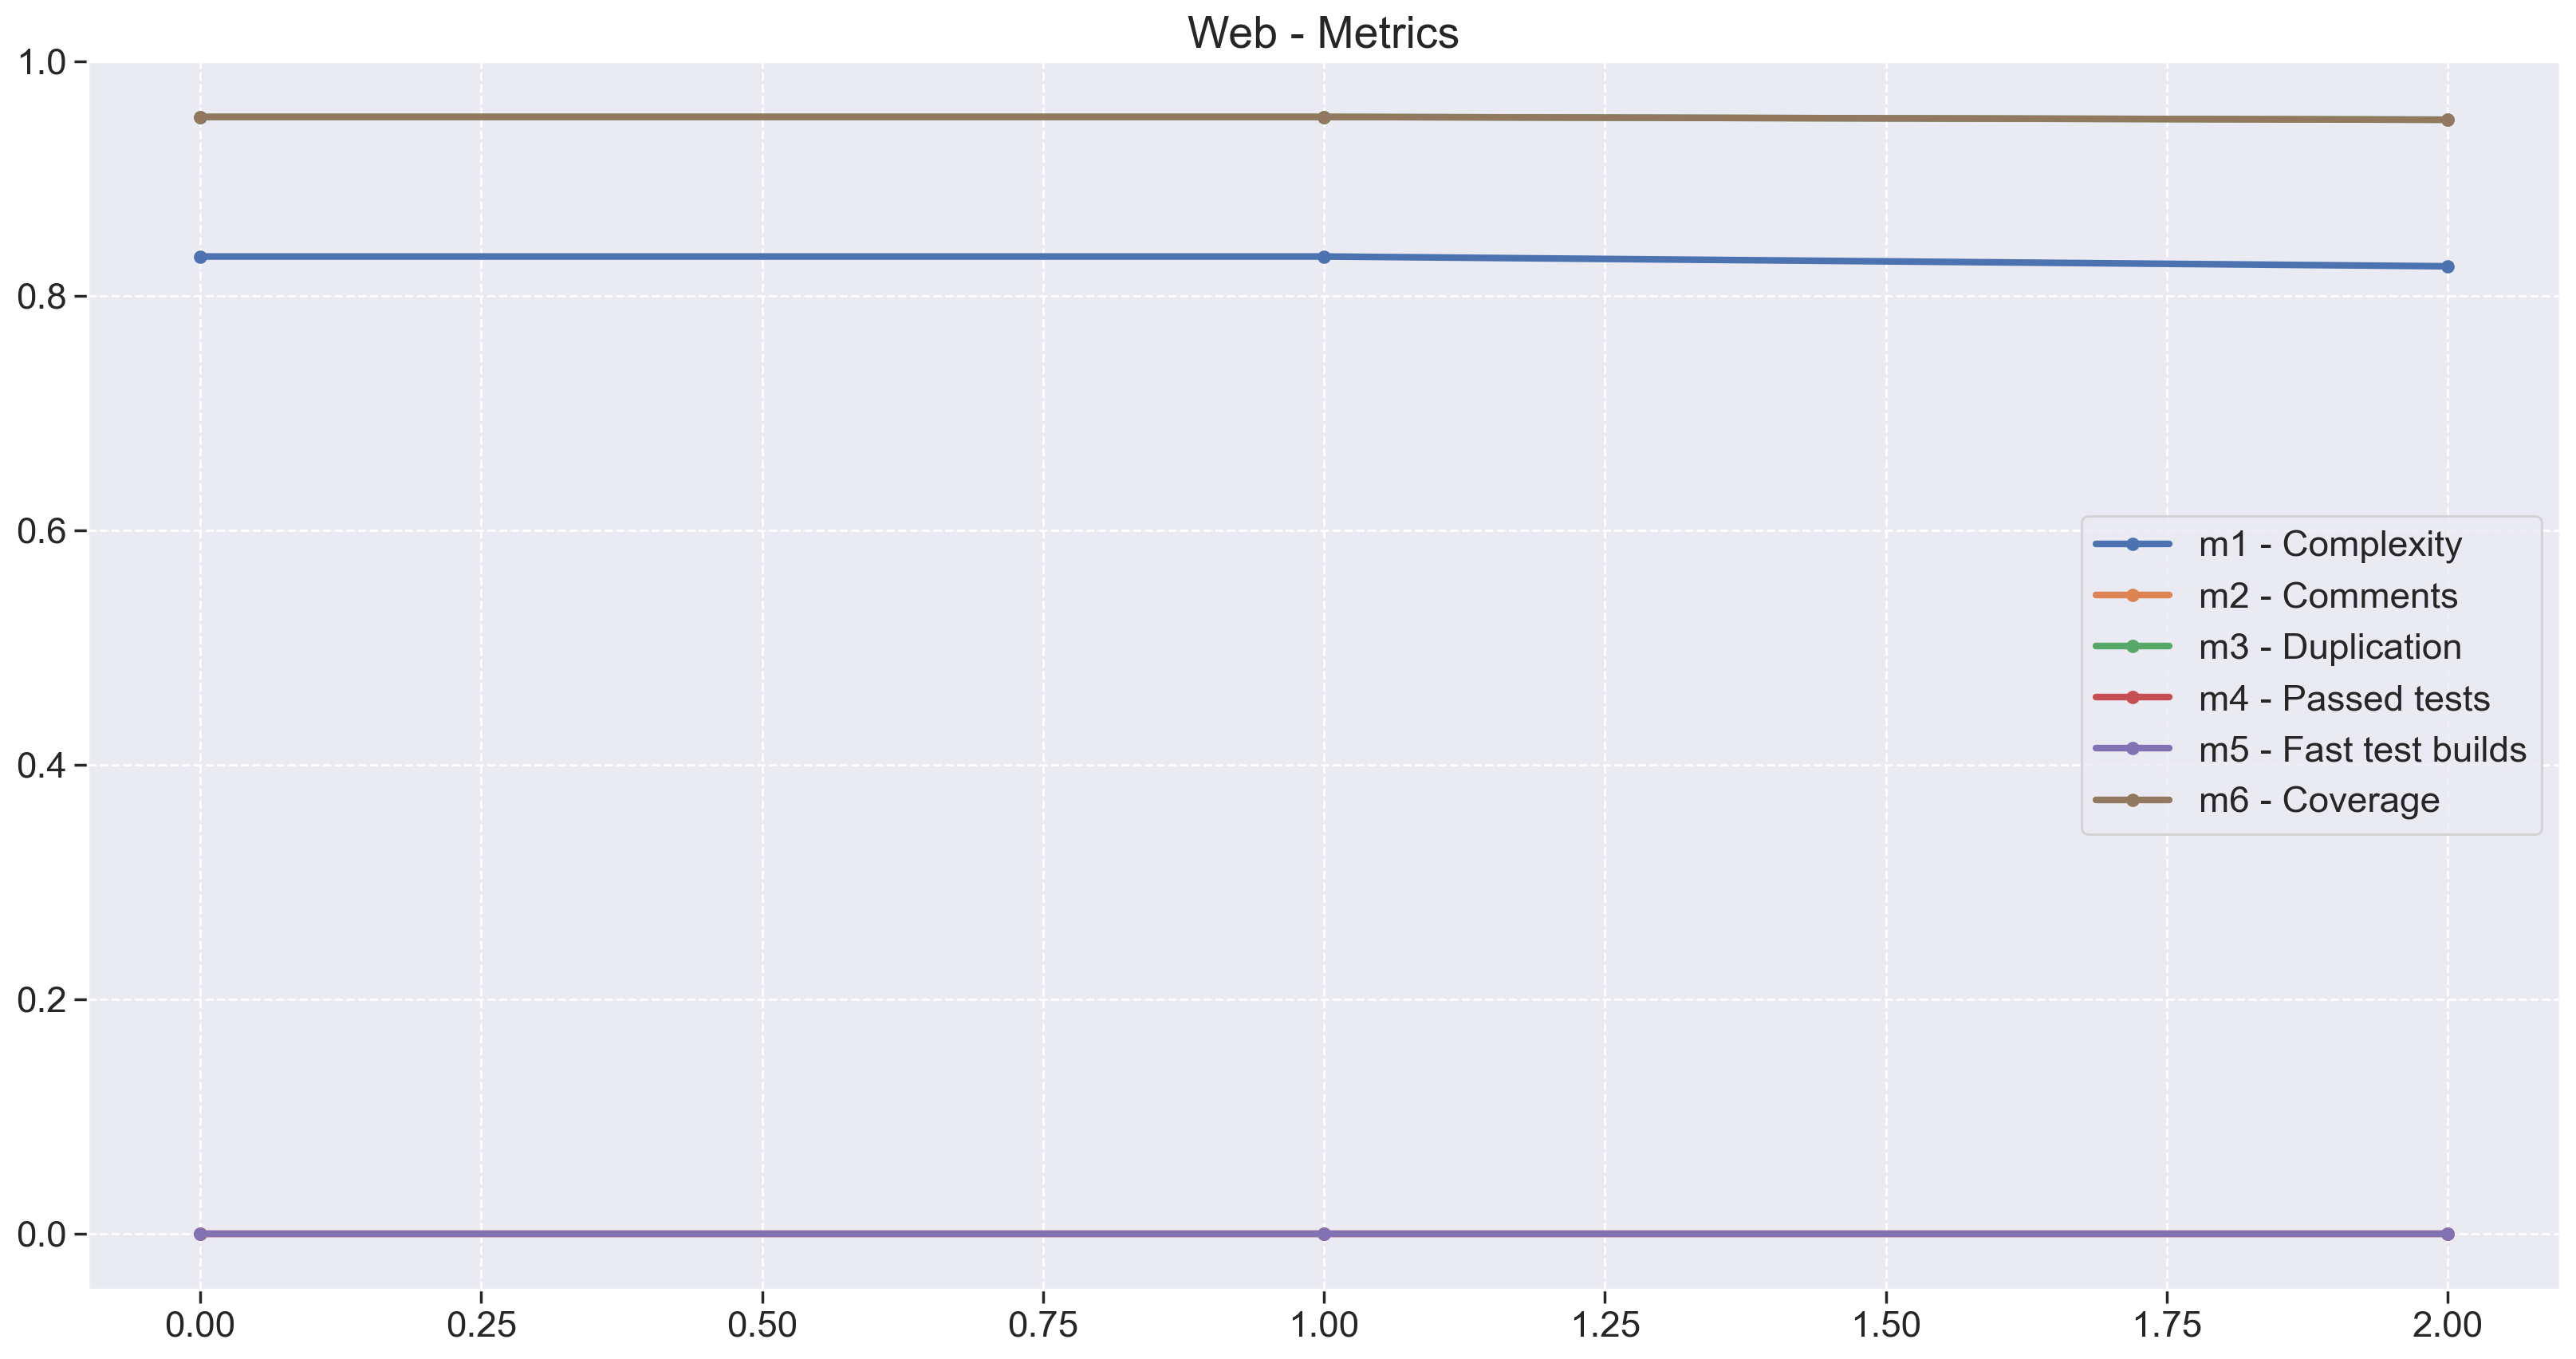

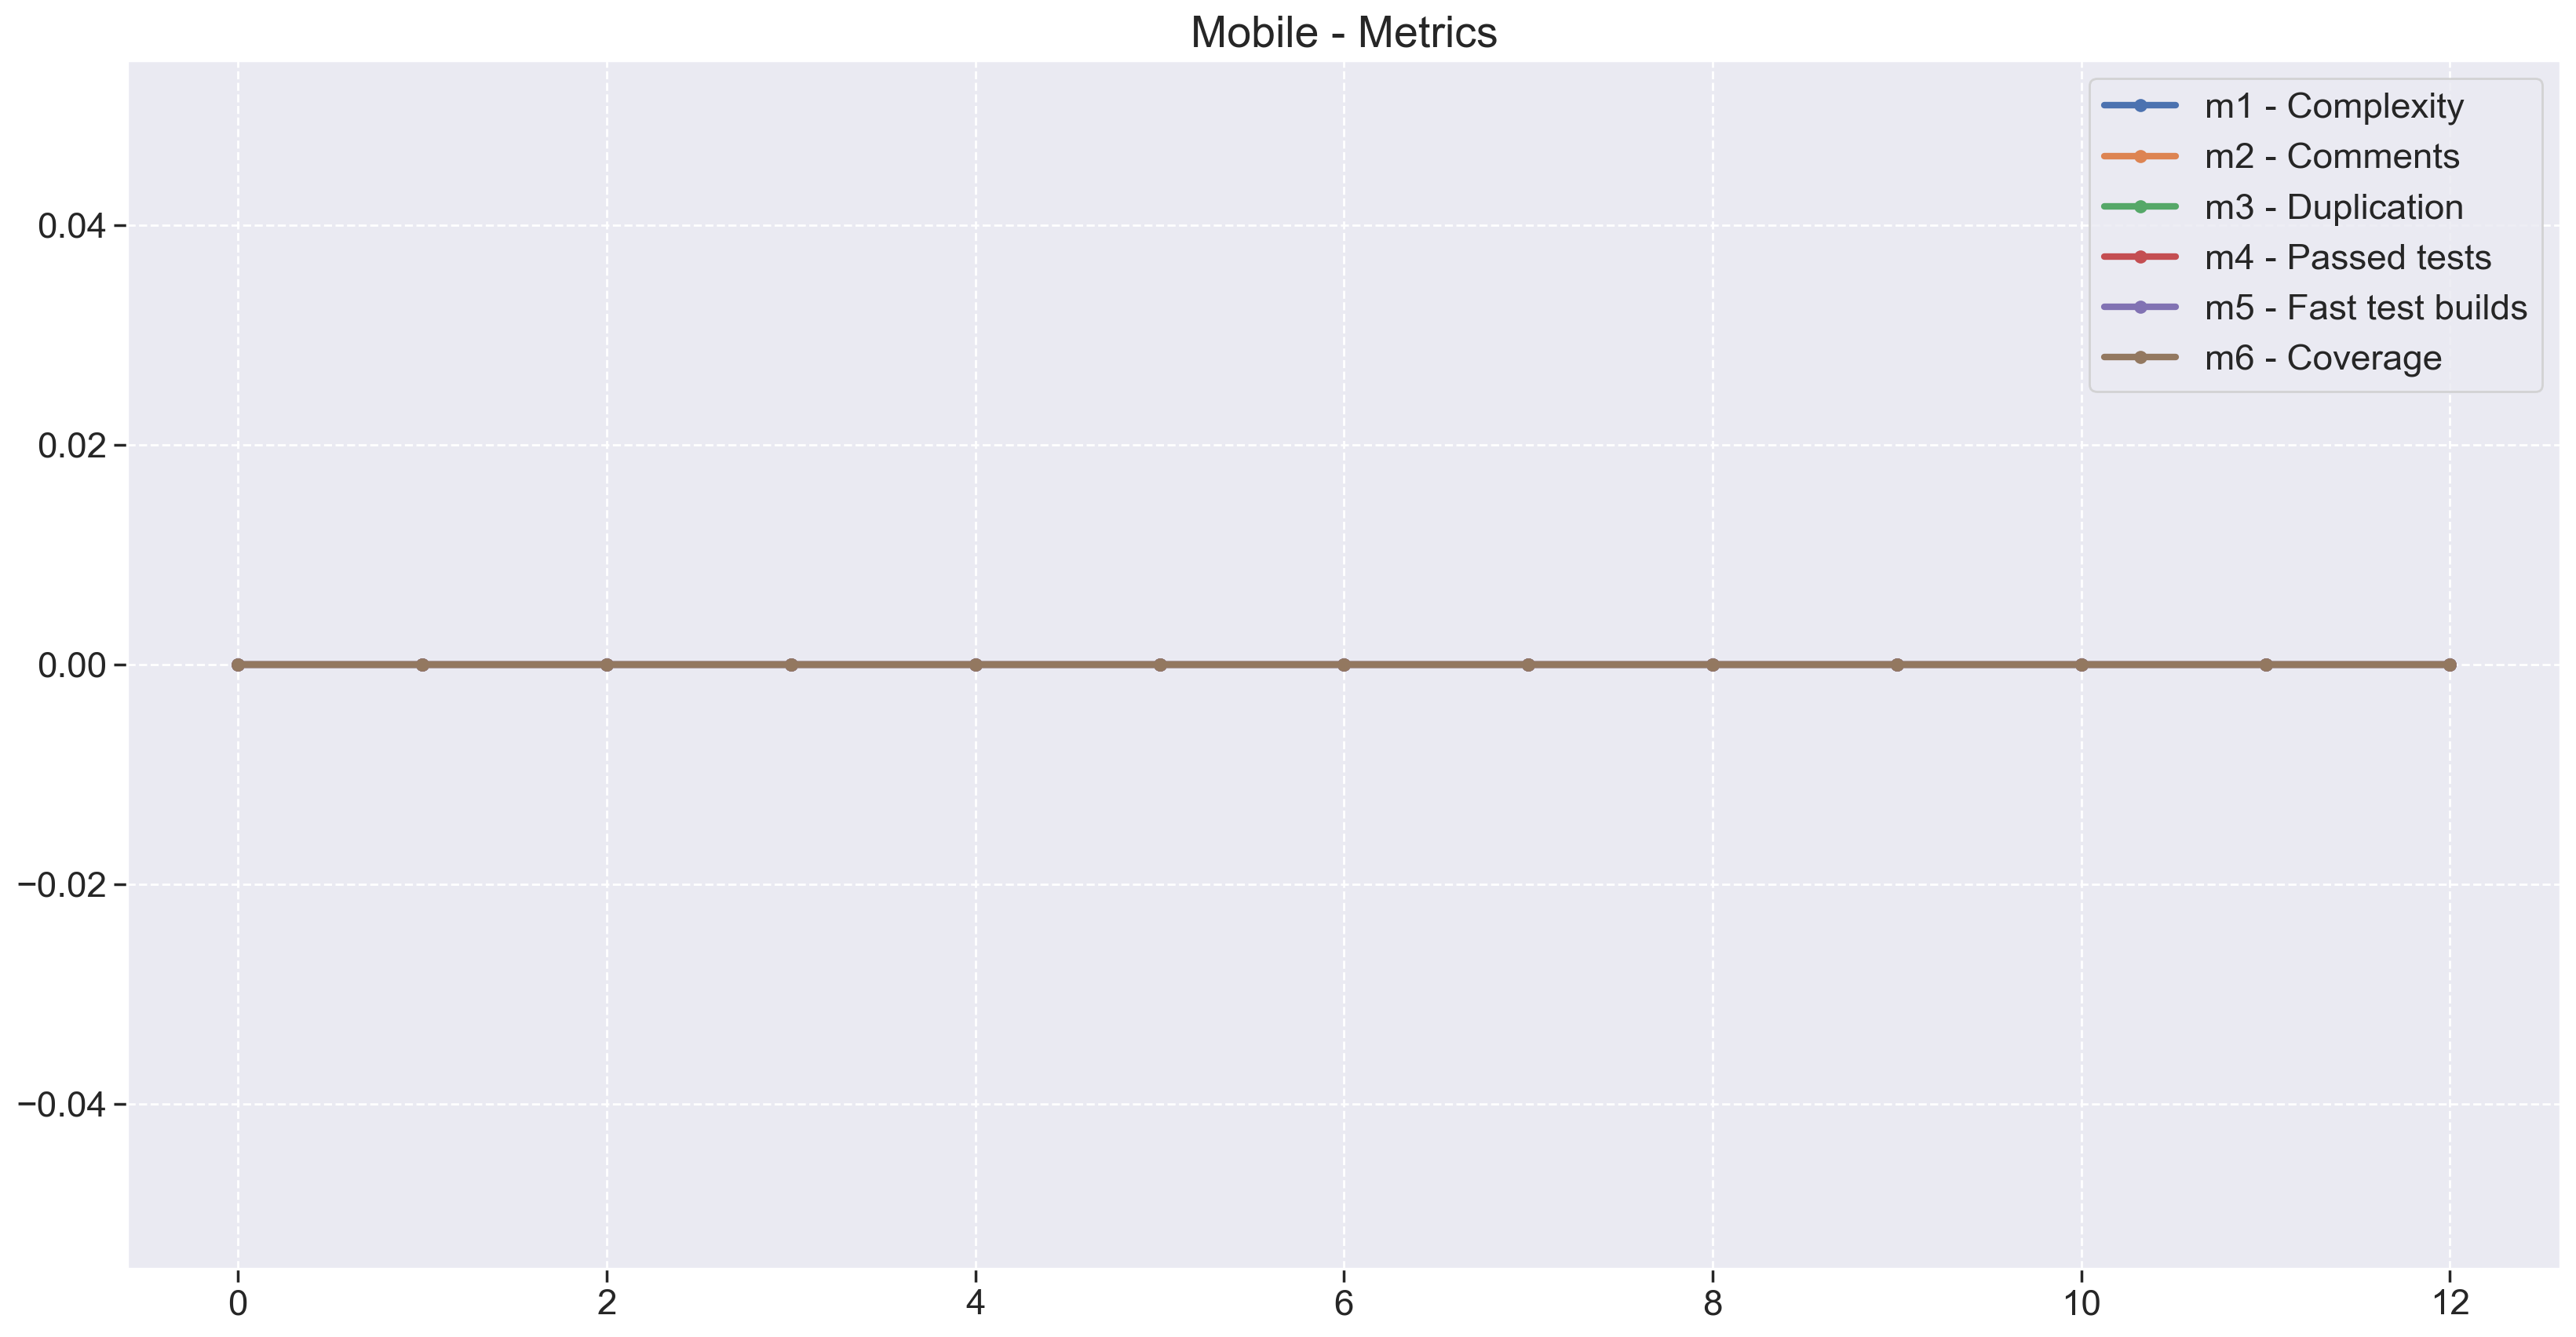

In [23]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='o', markersize=5, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='o', markersize=5, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='o', markersize=5, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='o', markersize=5, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='o', markersize=5, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='o', markersize=5, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

In [24]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository, in this case, we have 4 repositories

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

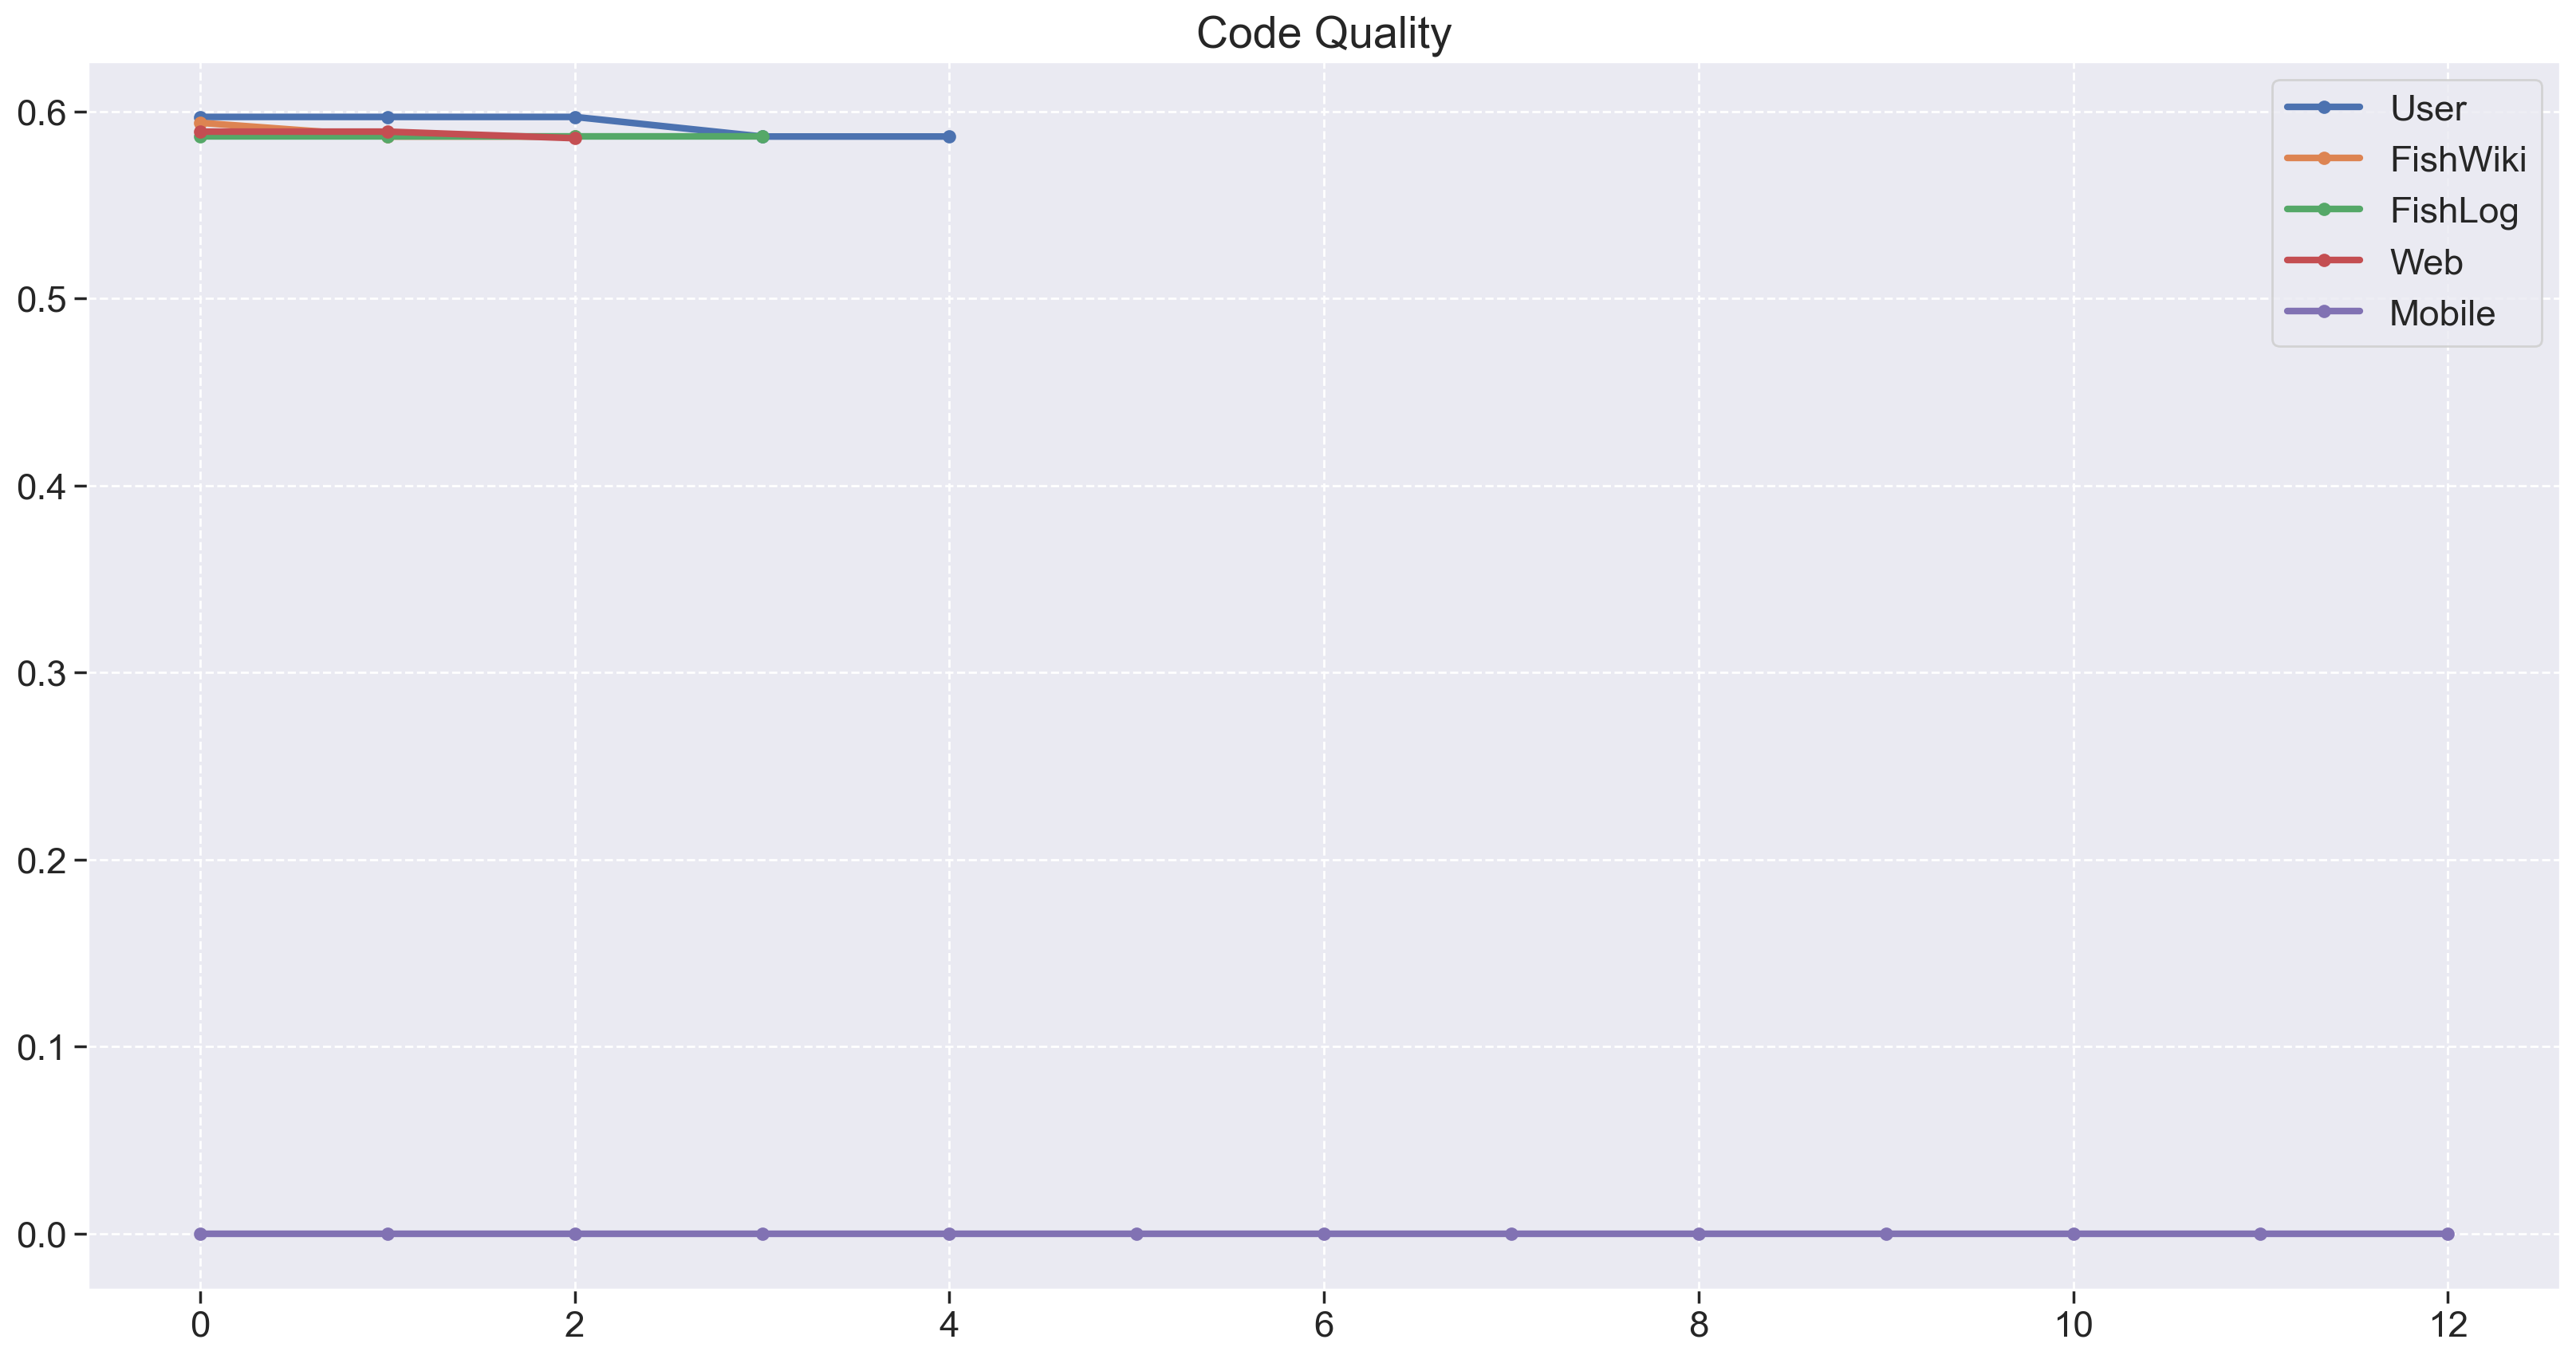

In [25]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=5, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

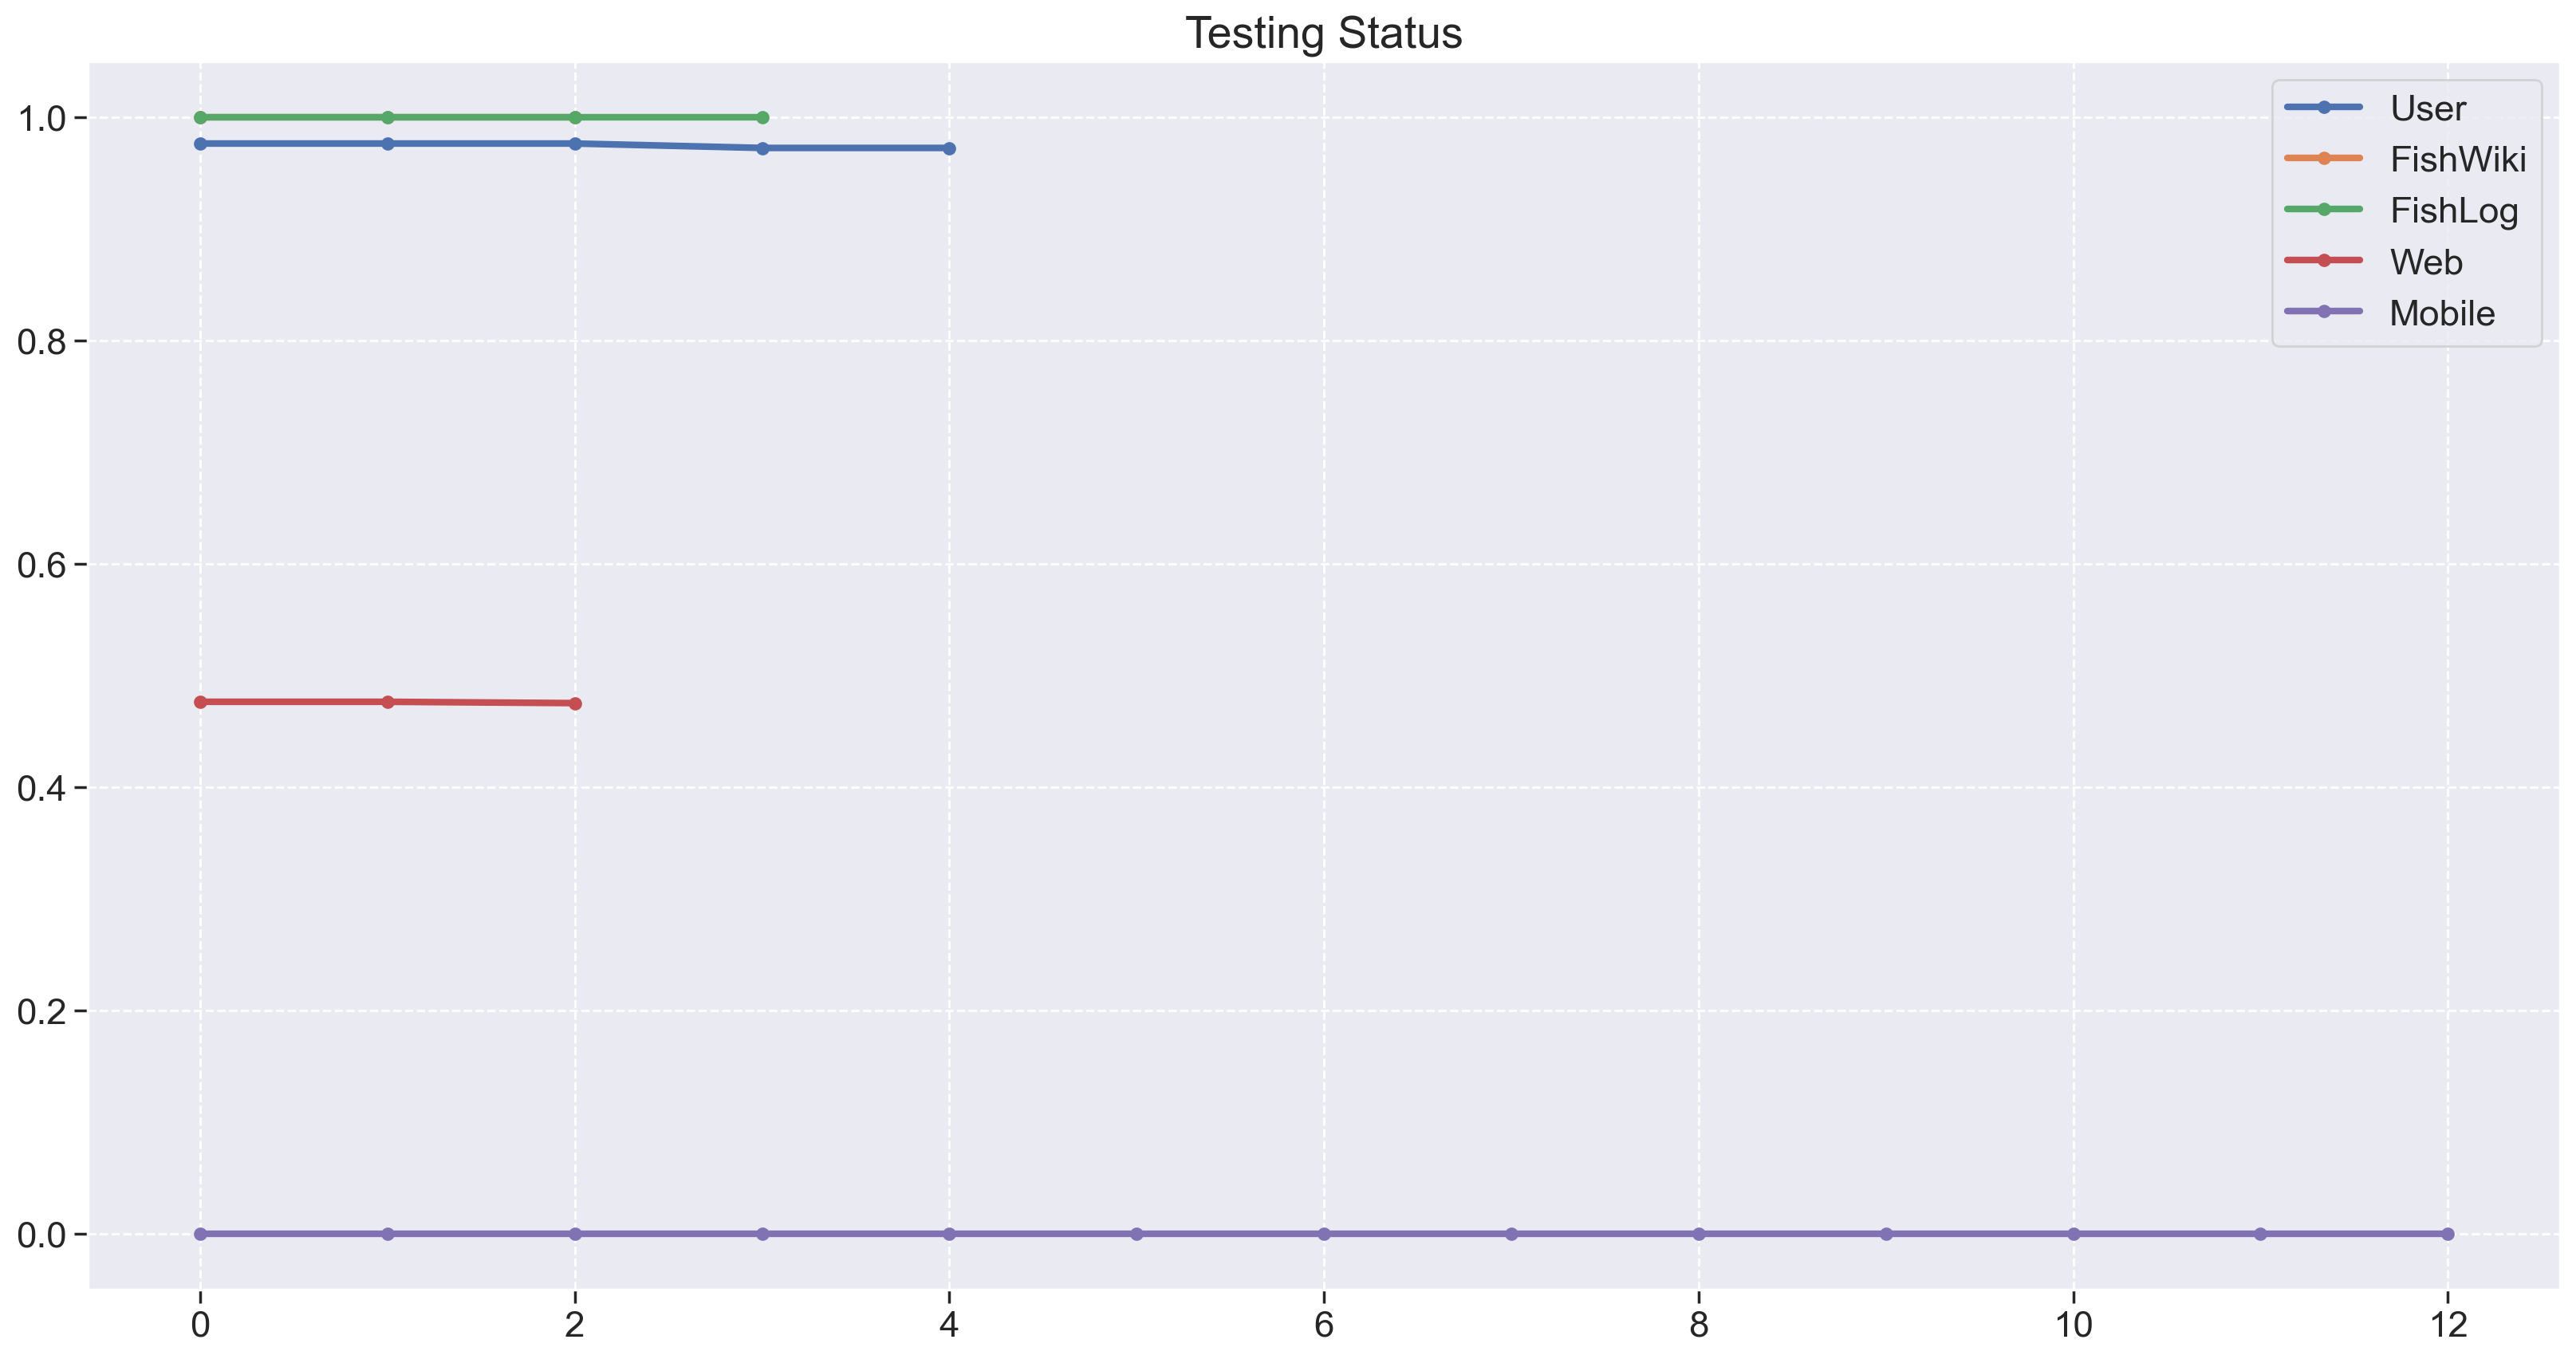

In [26]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=5, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')

In [27]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

In [28]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [29]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=5, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

Maintainability Stats
    mean     mode   median      std      var      min      max
0.296476 0.298571 0.298571 0.002869 0.000008 0.293333 0.298571
Reliability Stats
    mean     mode   median      std      var      min      max
0.487302 0.488095 0.488095 0.001087 0.000001 0.486111 0.488095


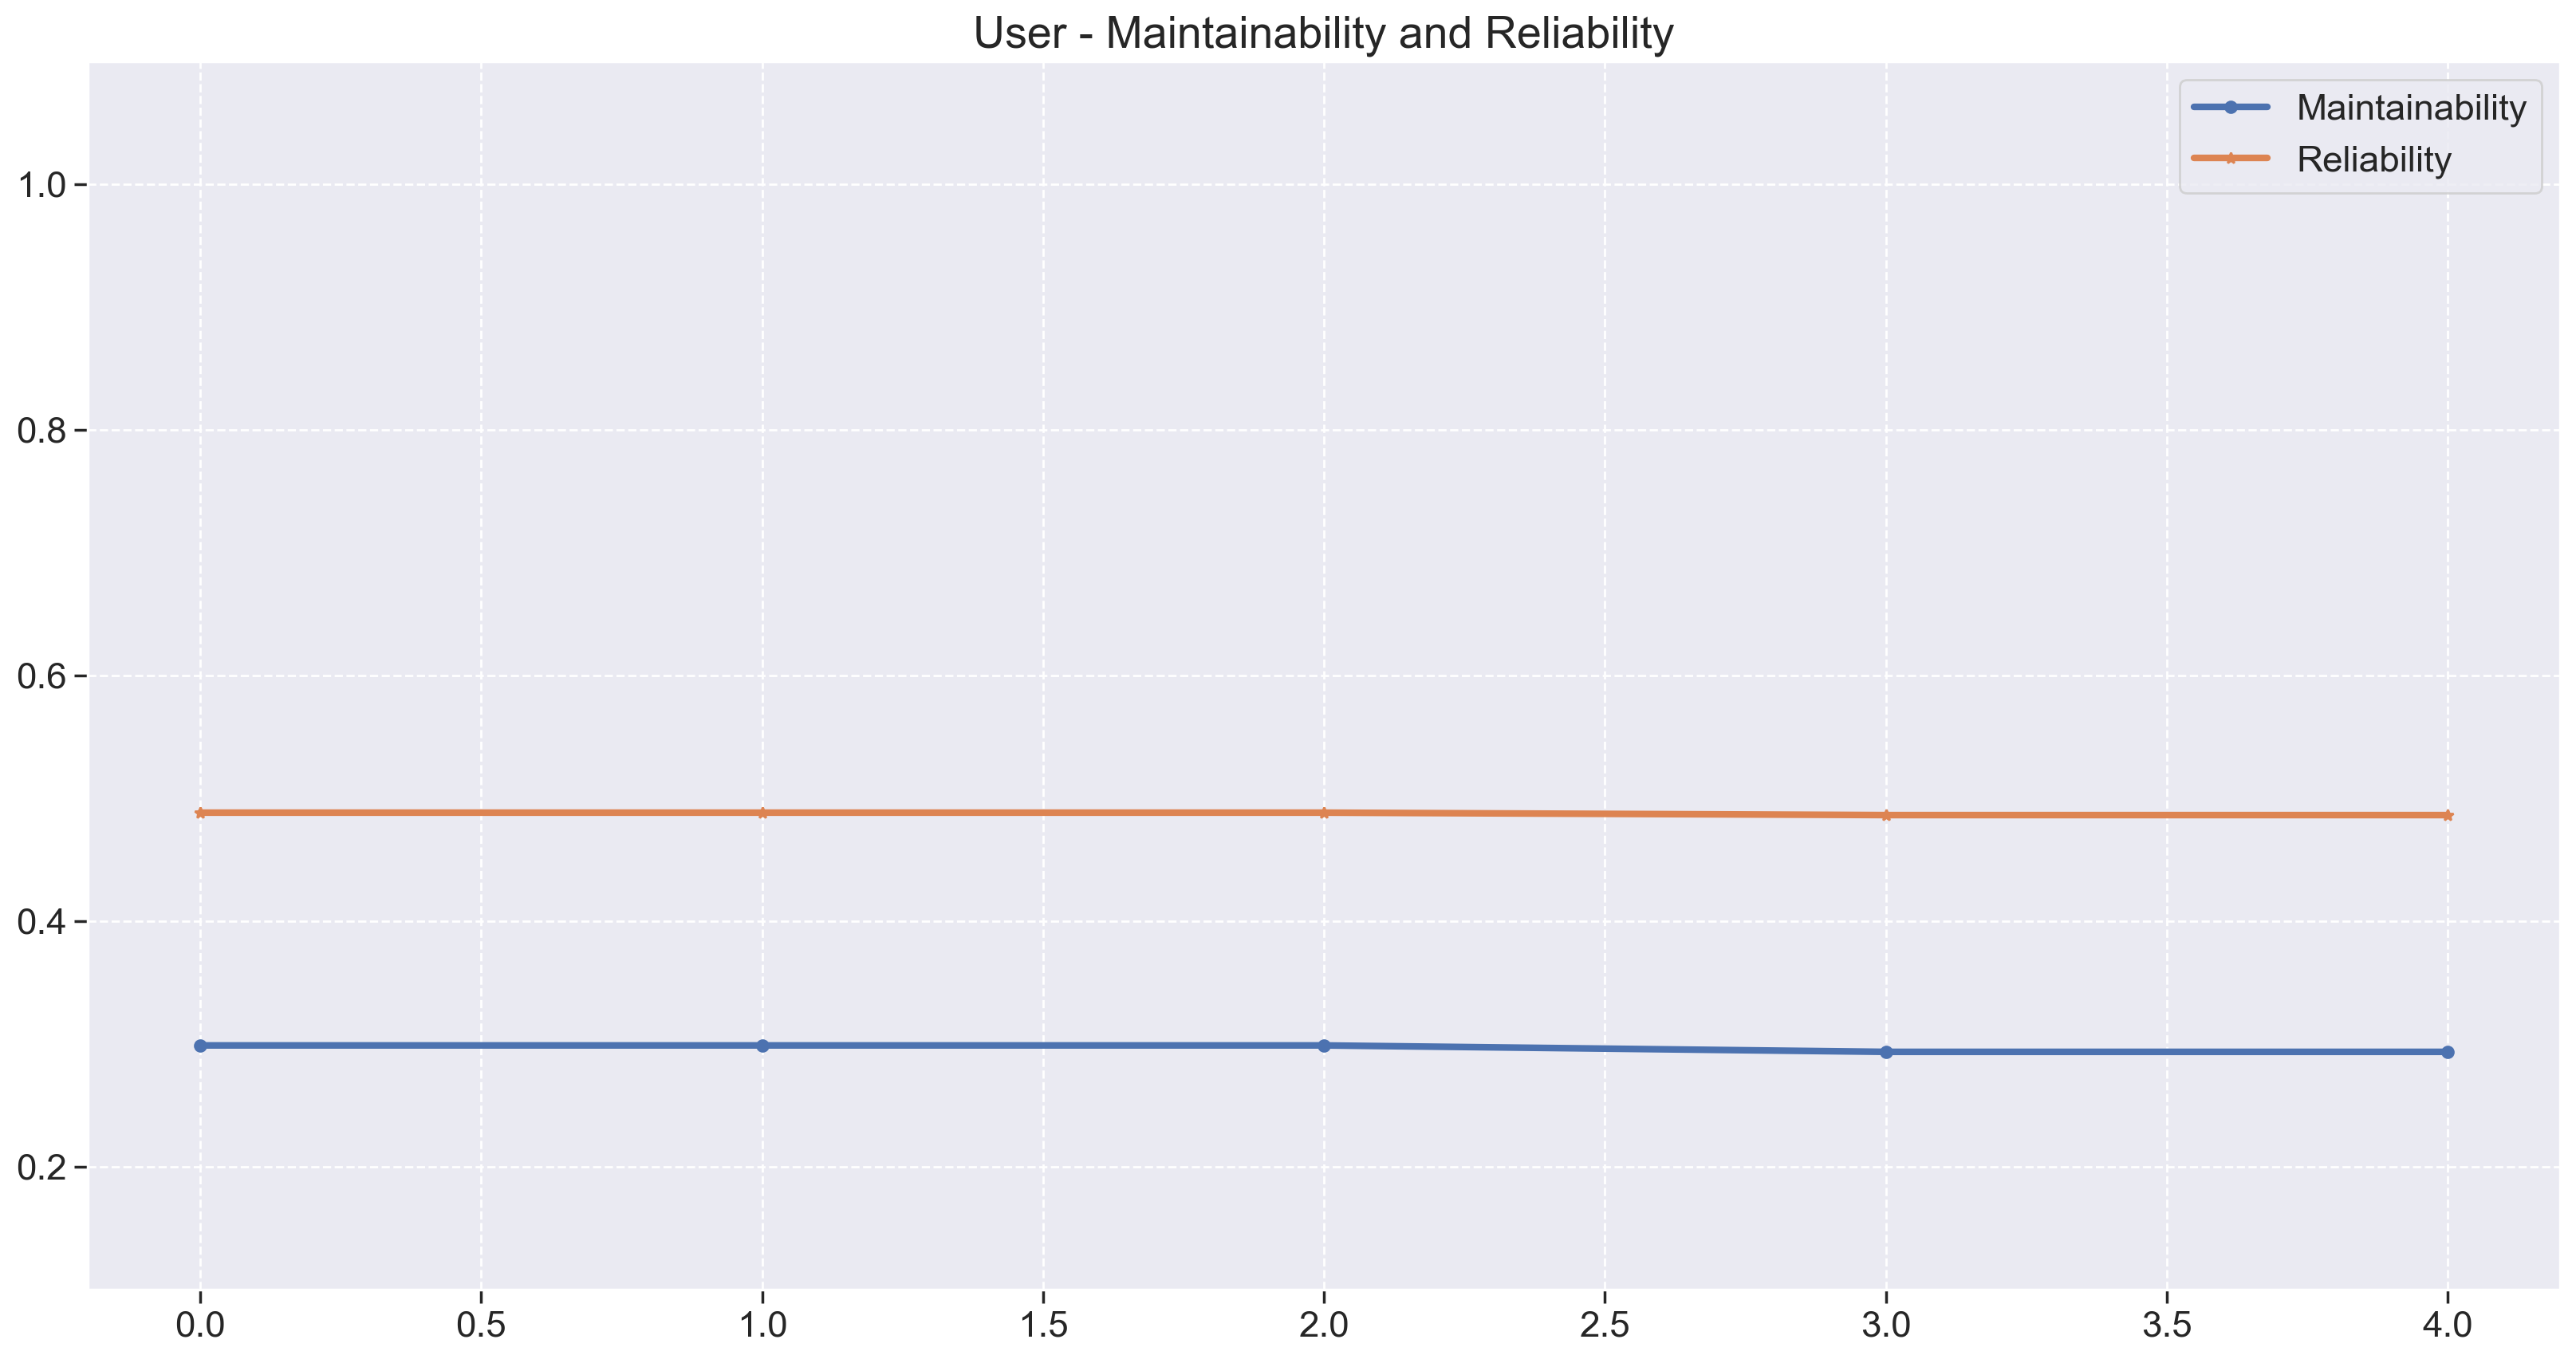

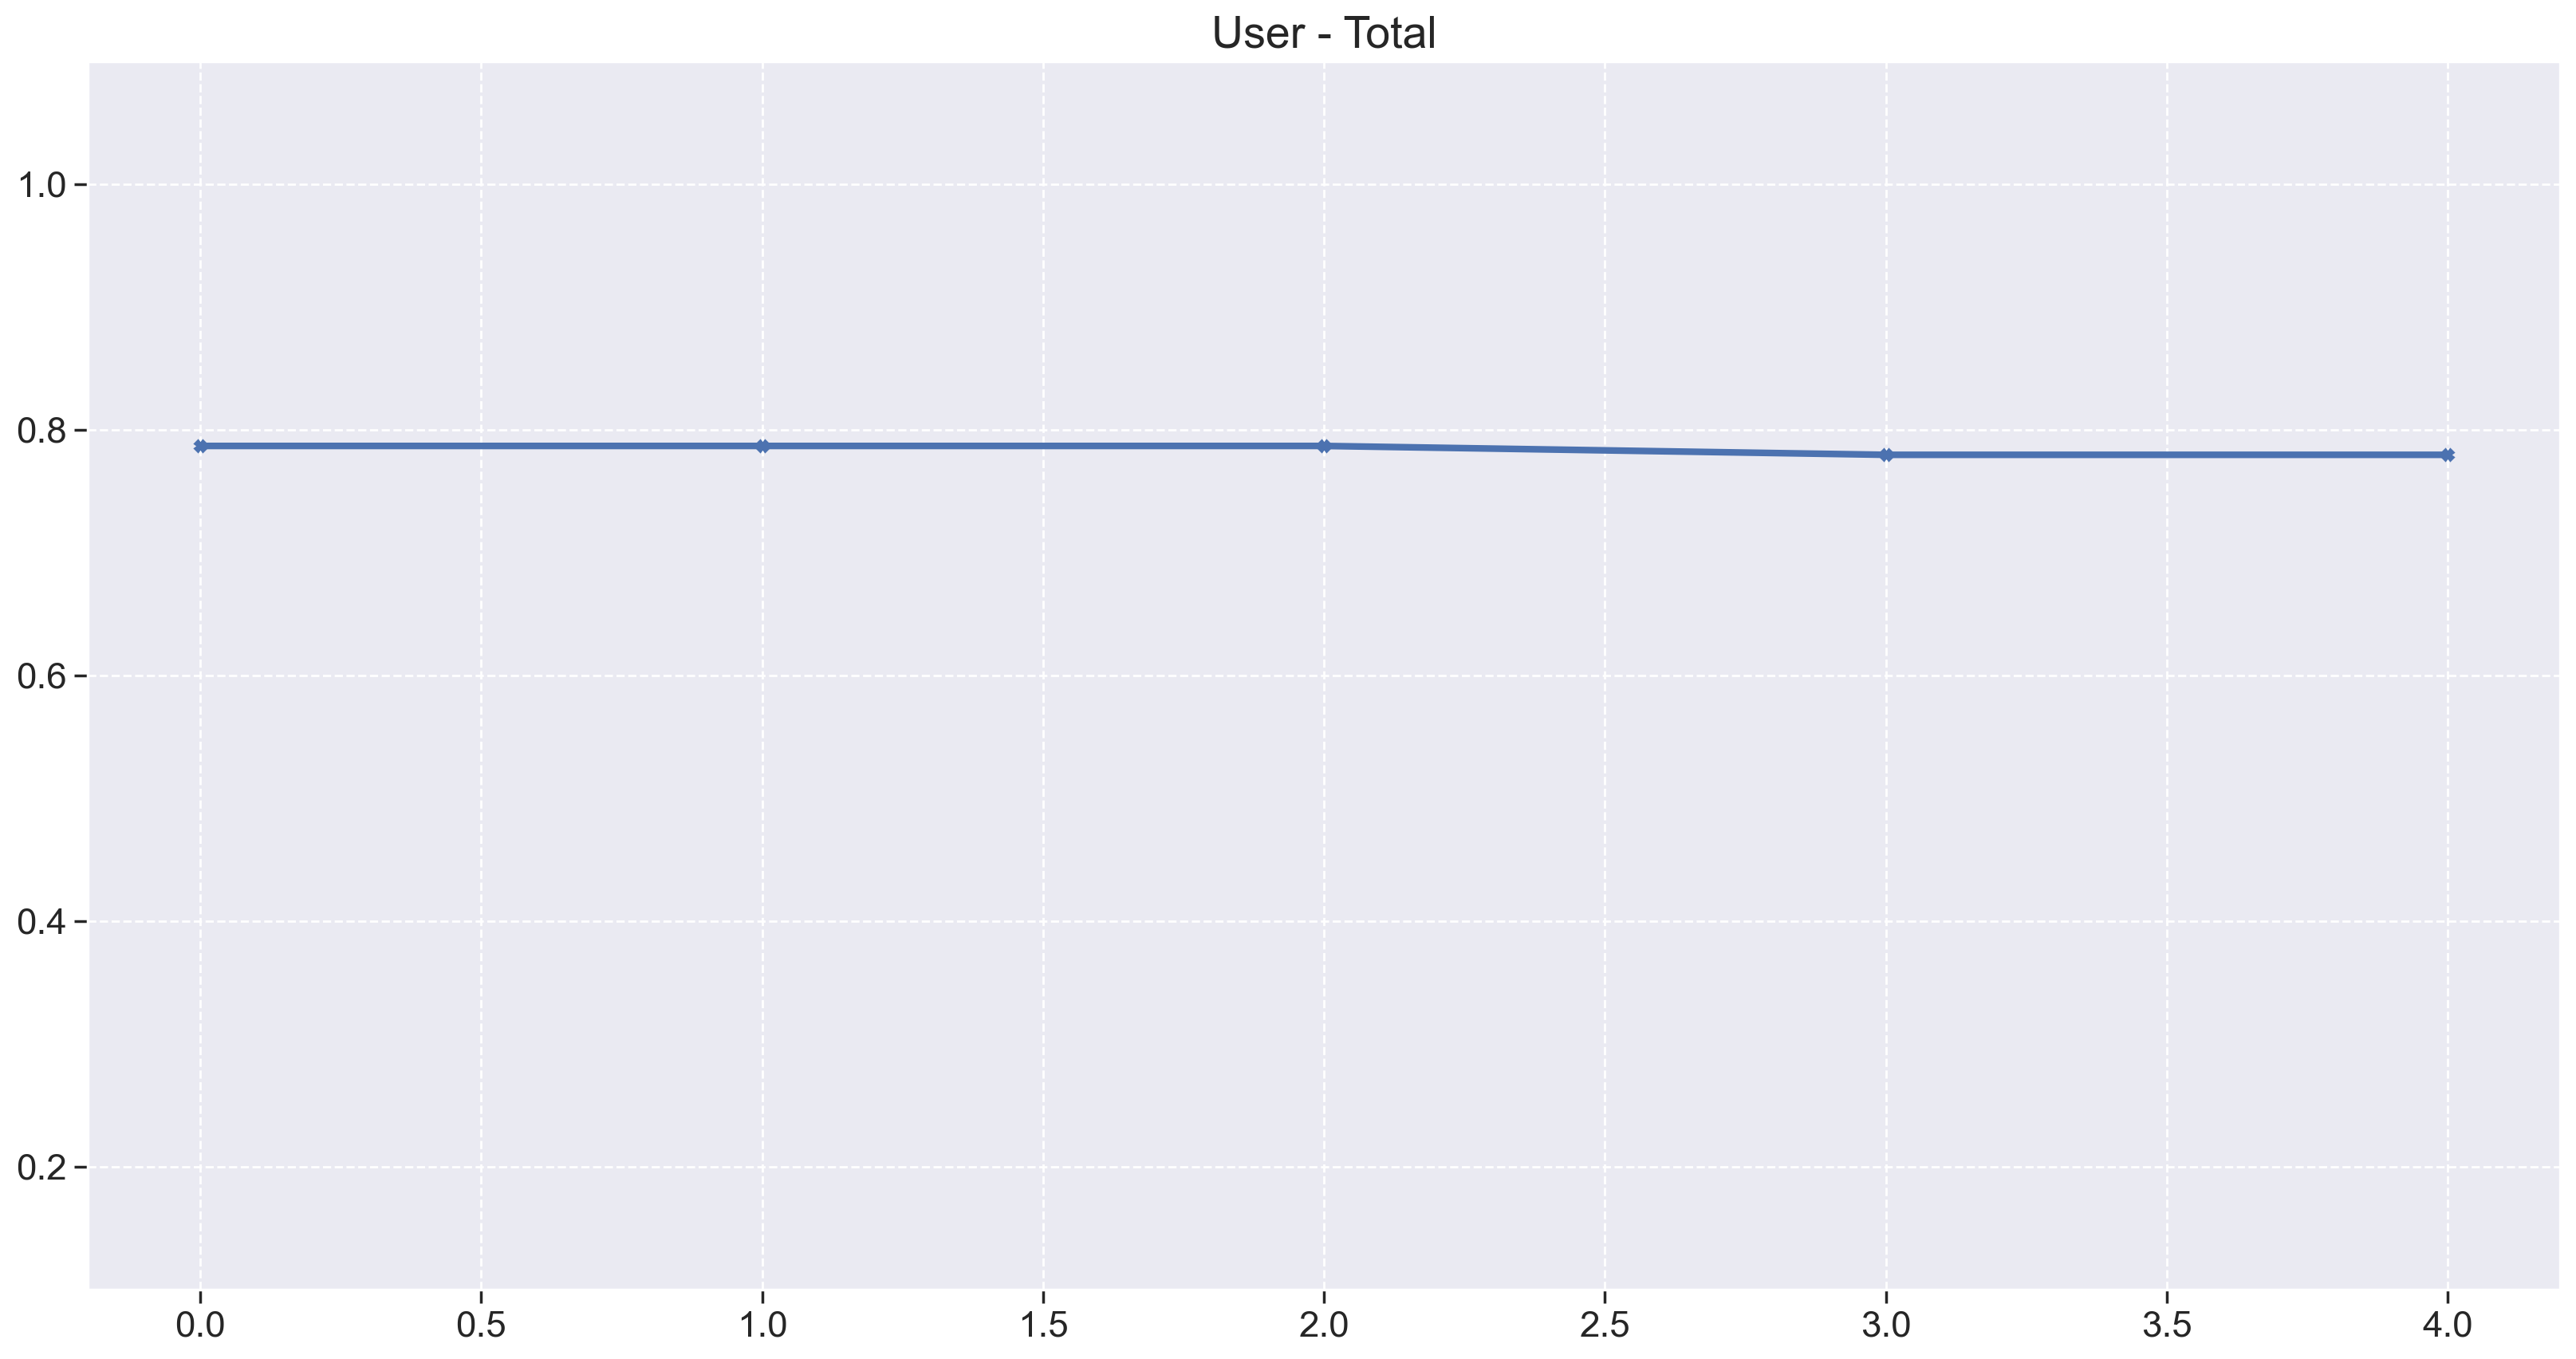

Maintainability Stats
    mean     mode   median      std      var      min   max
0.294556 0.293333 0.293333 0.002117 0.000004 0.293333 0.297
Reliability Stats
 mean  mode  median  std  var  min  max
  0.5   0.5     0.5  0.0  0.0  0.5  0.5


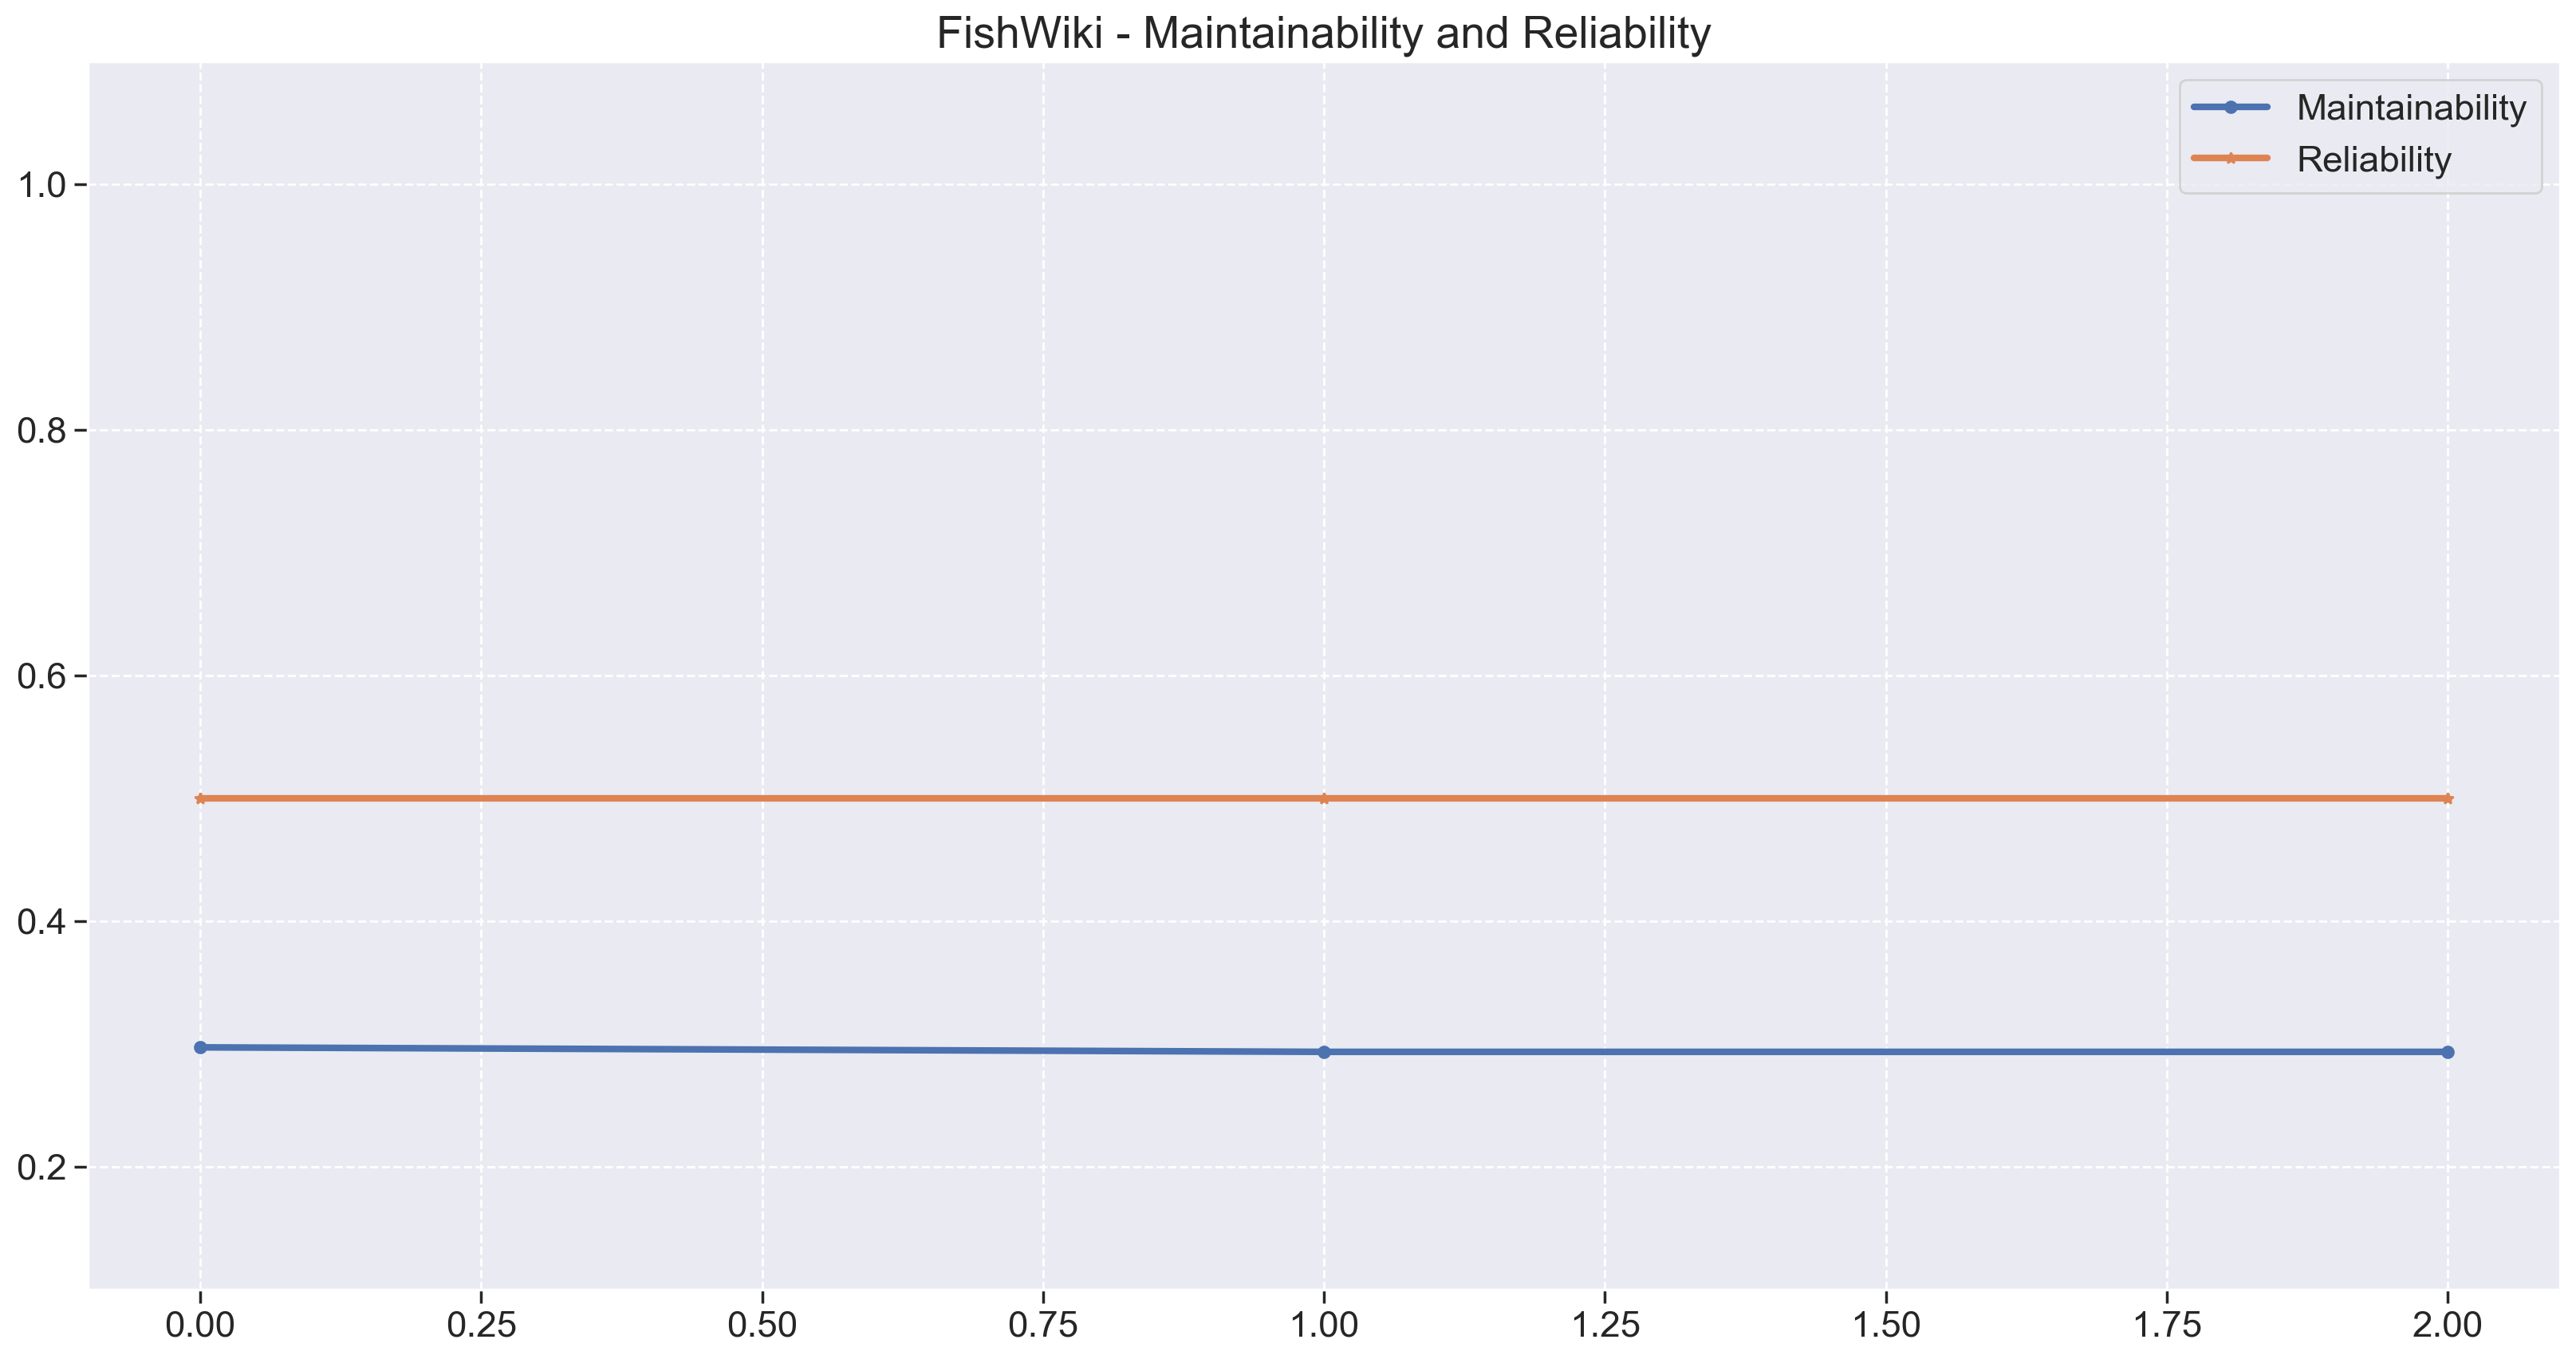

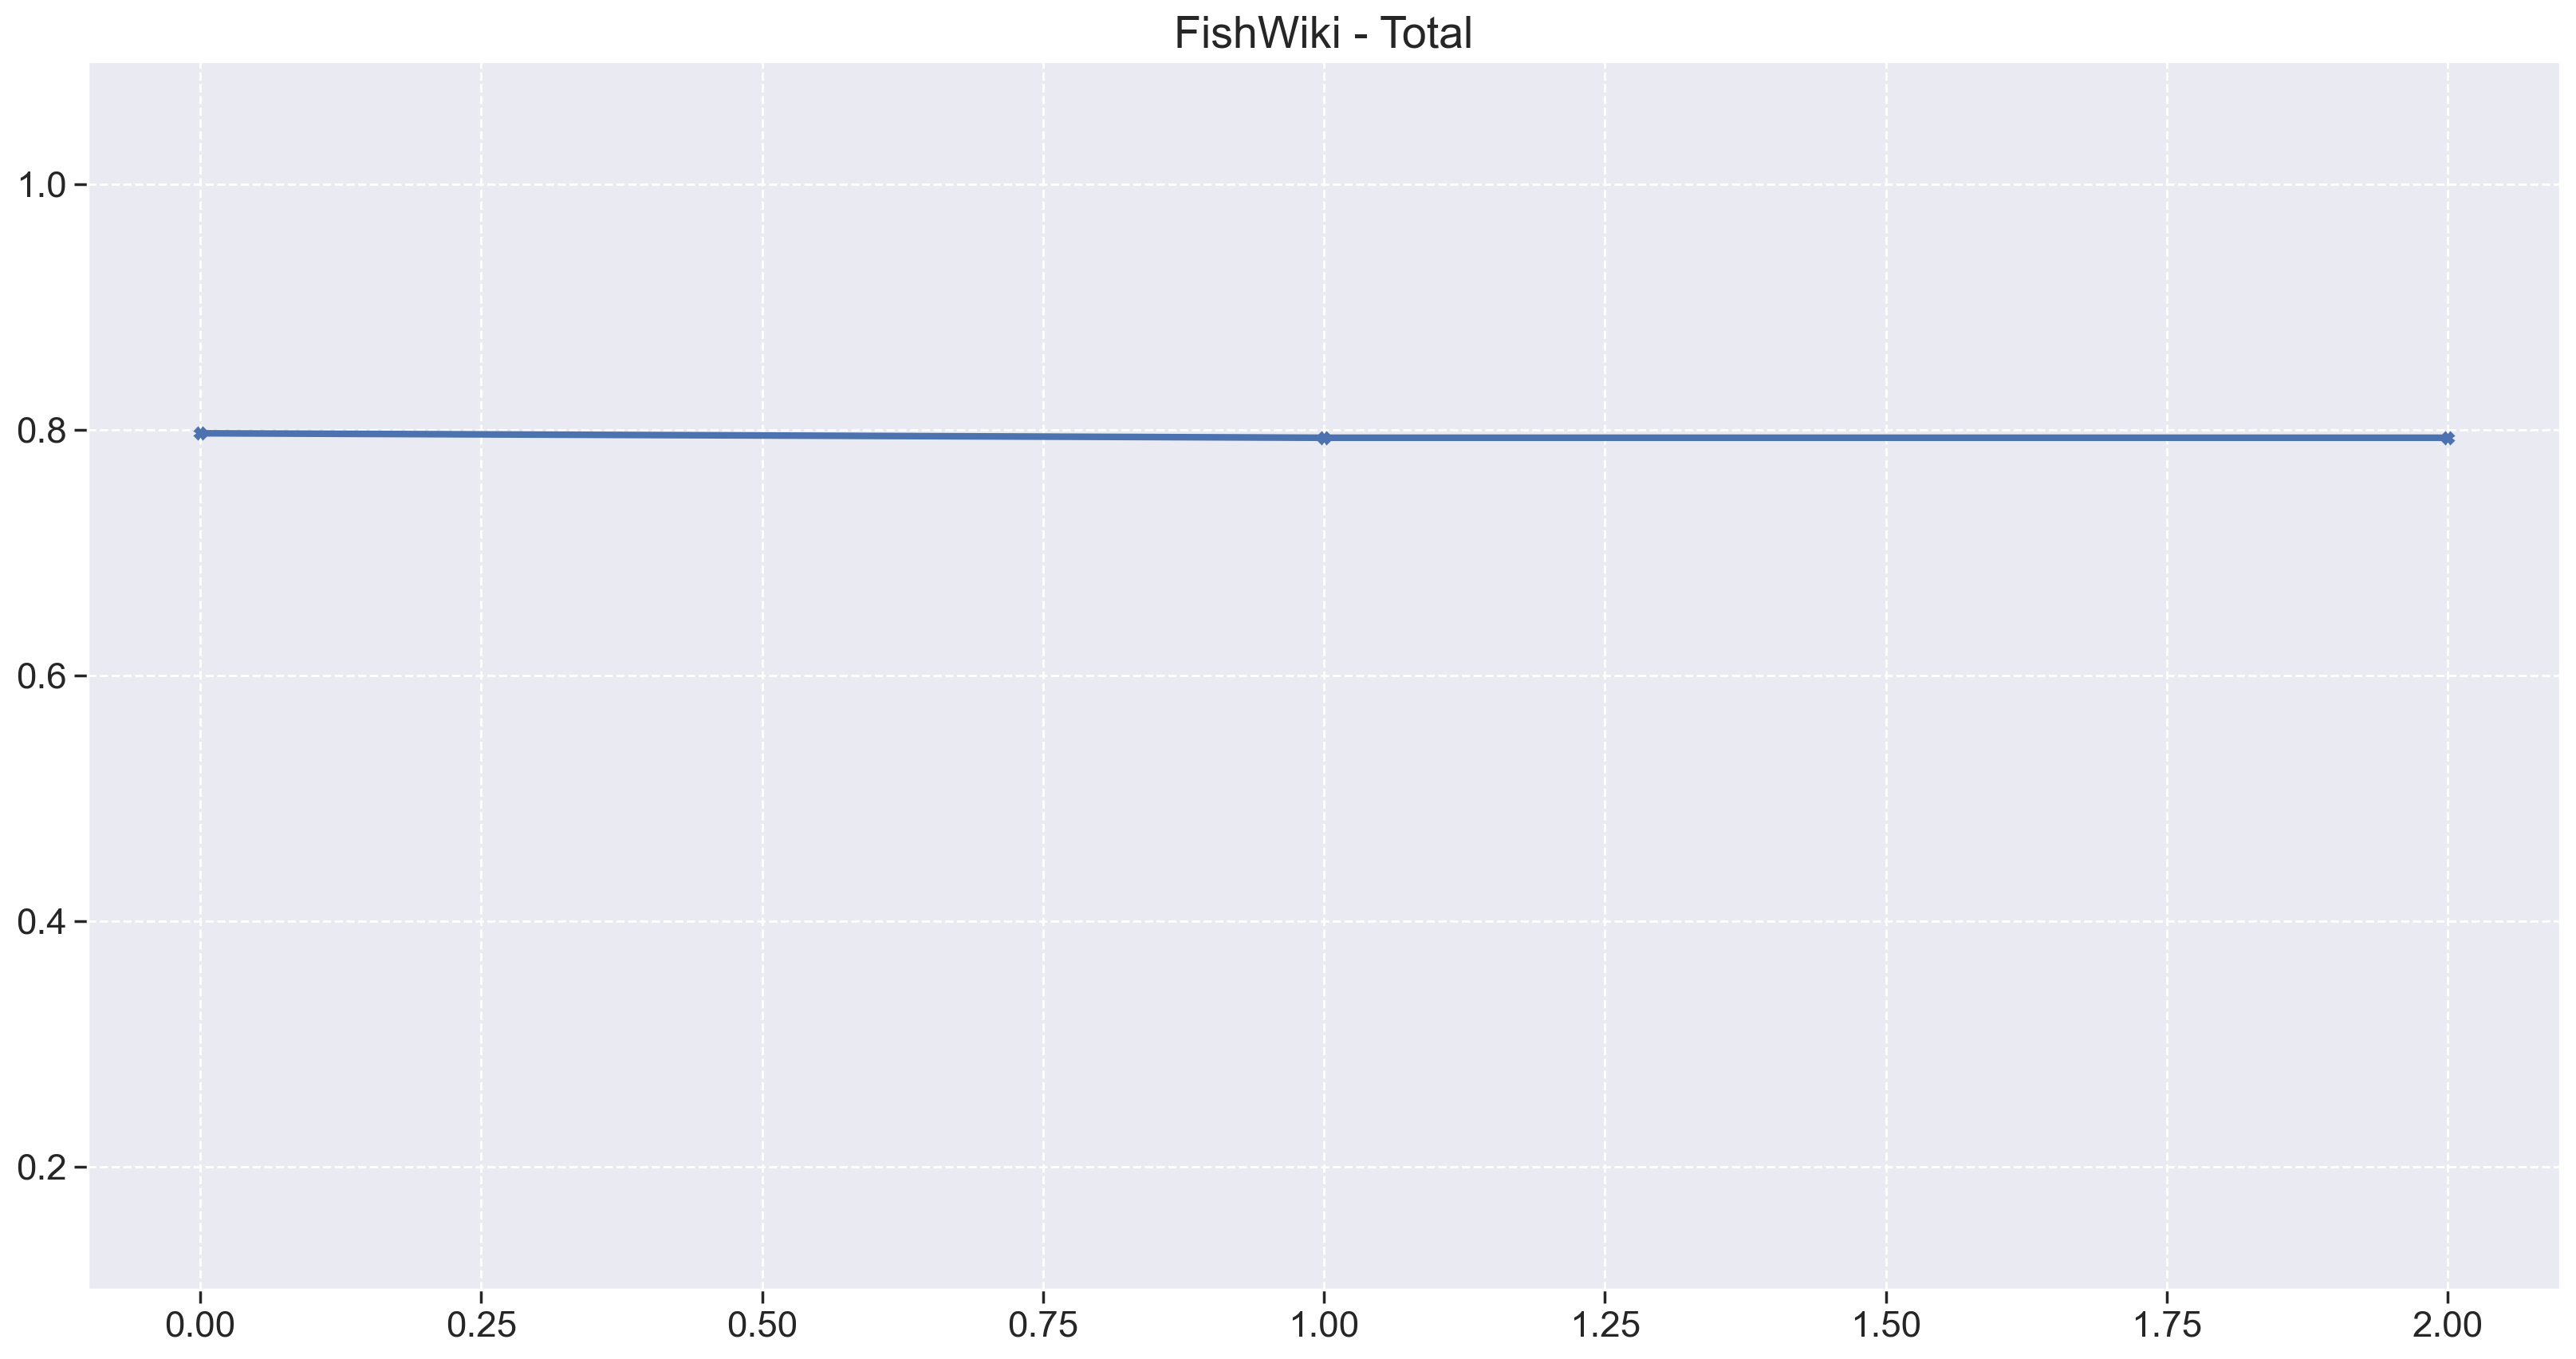

Maintainability Stats
    mean     mode   median  std  var      min      max
0.293333 0.293333 0.293333  0.0  0.0 0.293333 0.293333
Reliability Stats
 mean  mode  median  std  var  min  max
  0.5   0.5     0.5  0.0  0.0  0.5  0.5


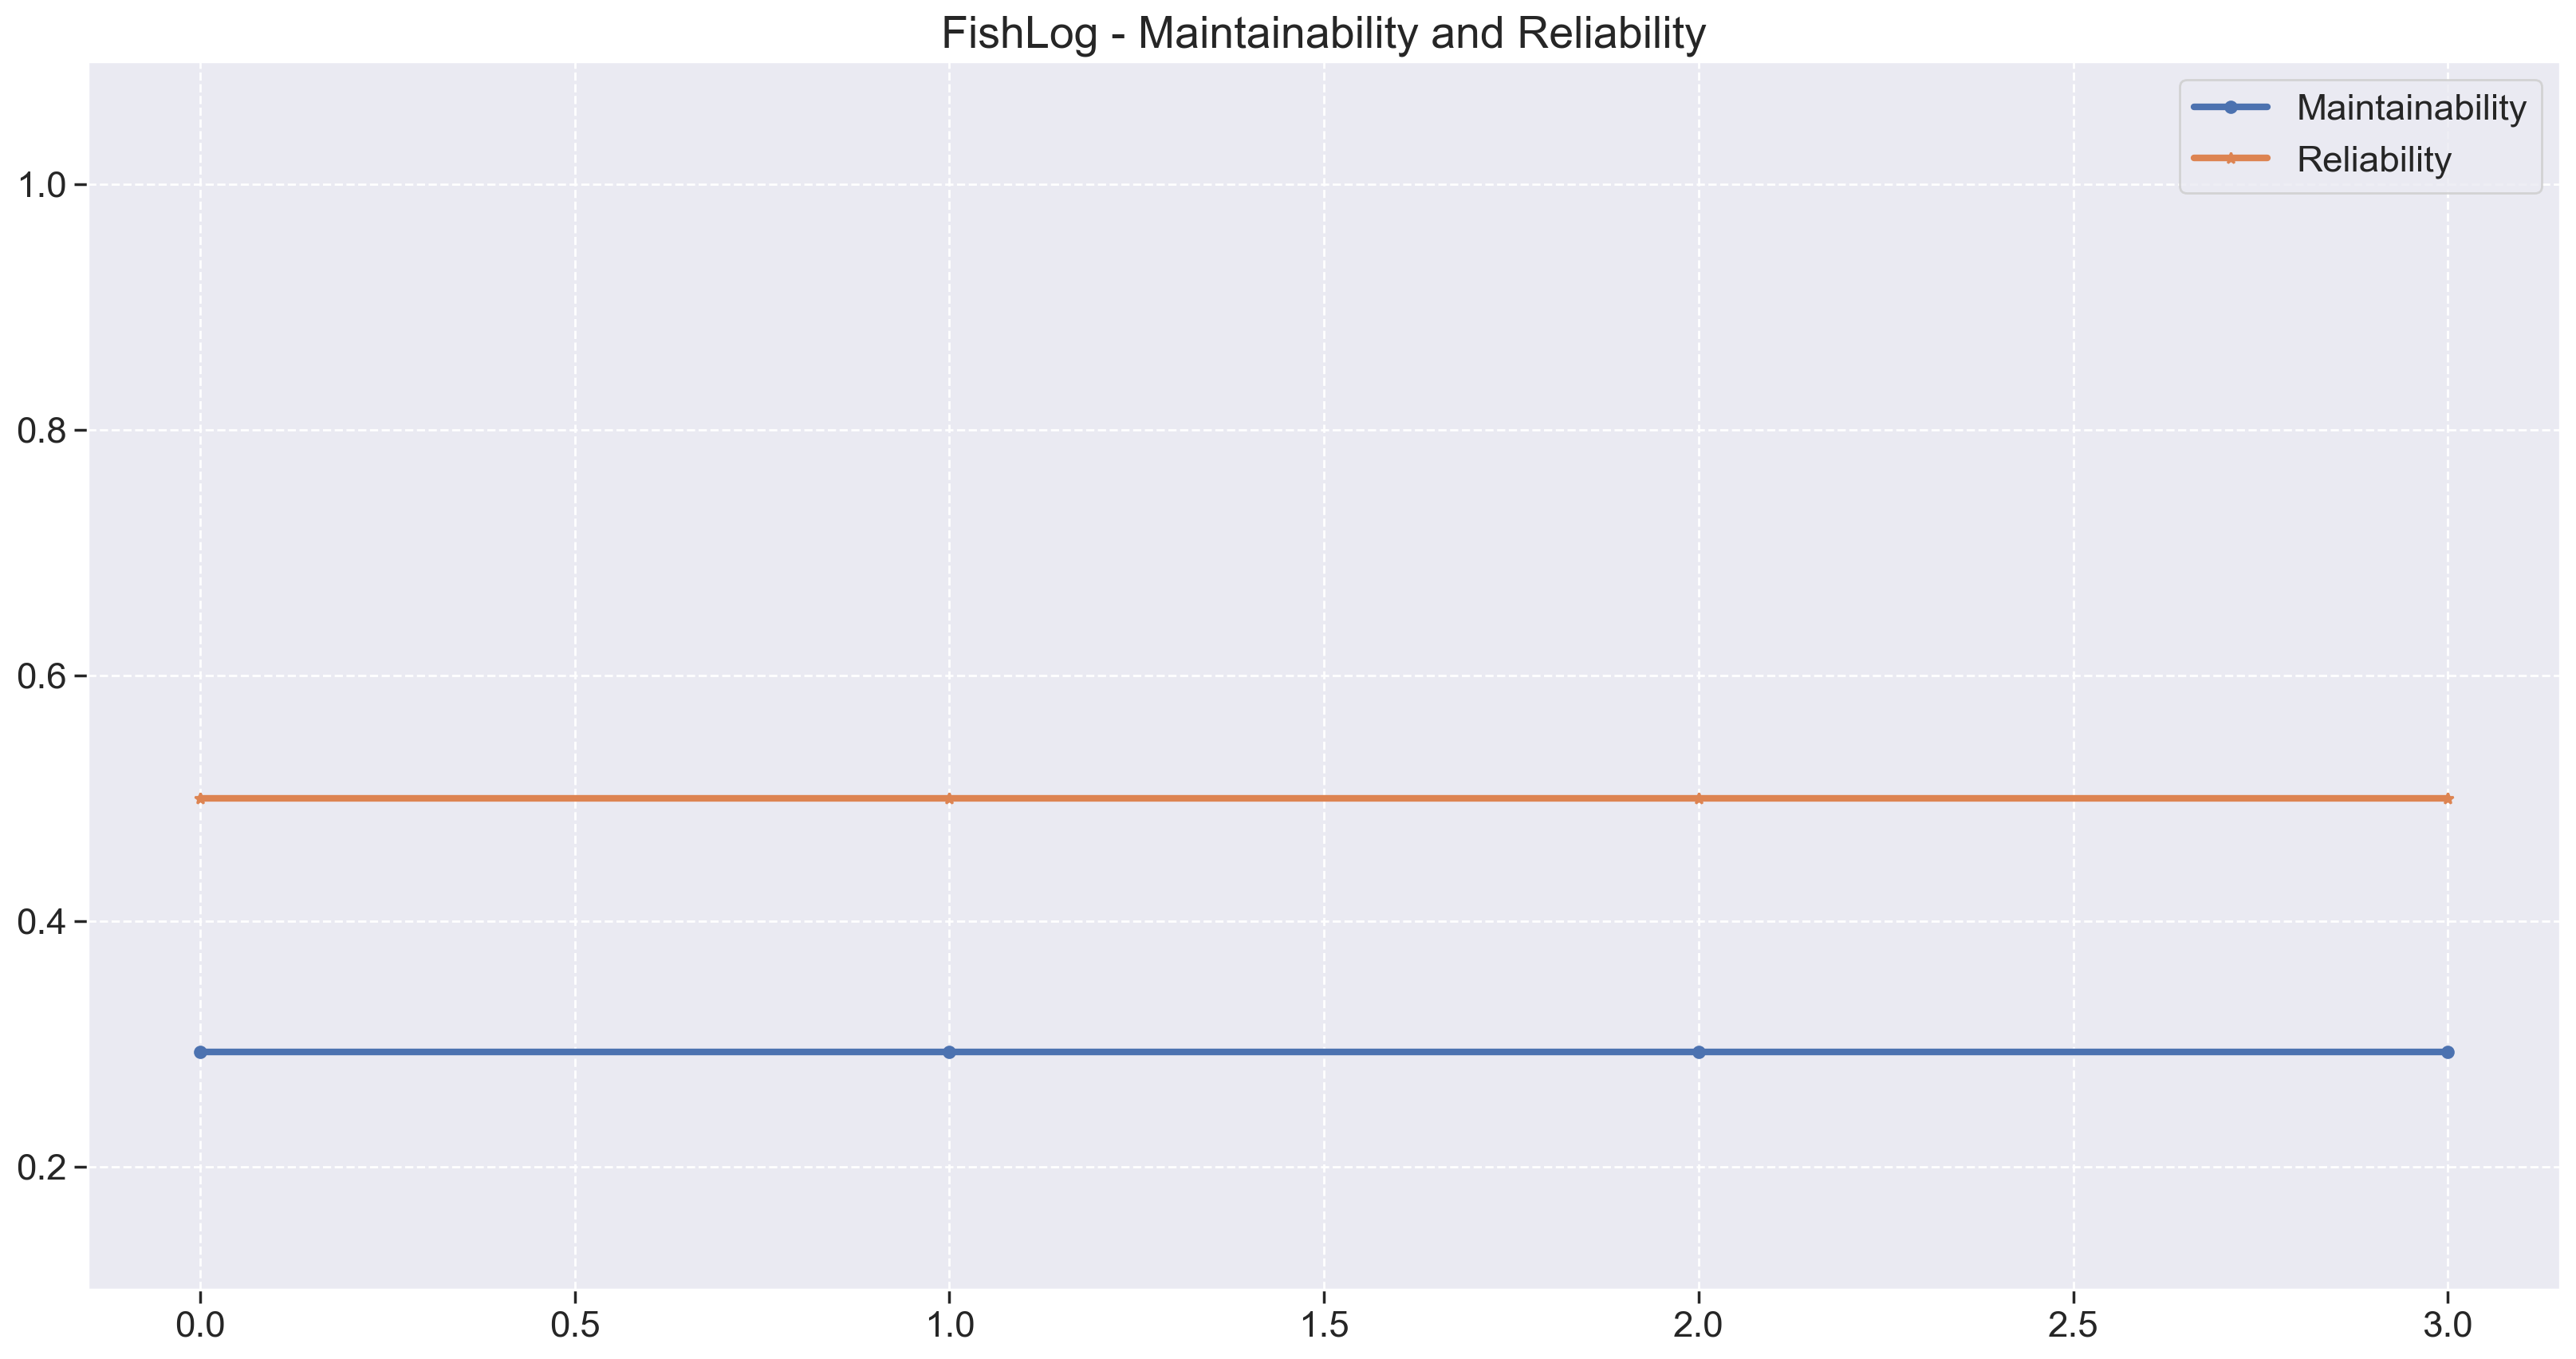

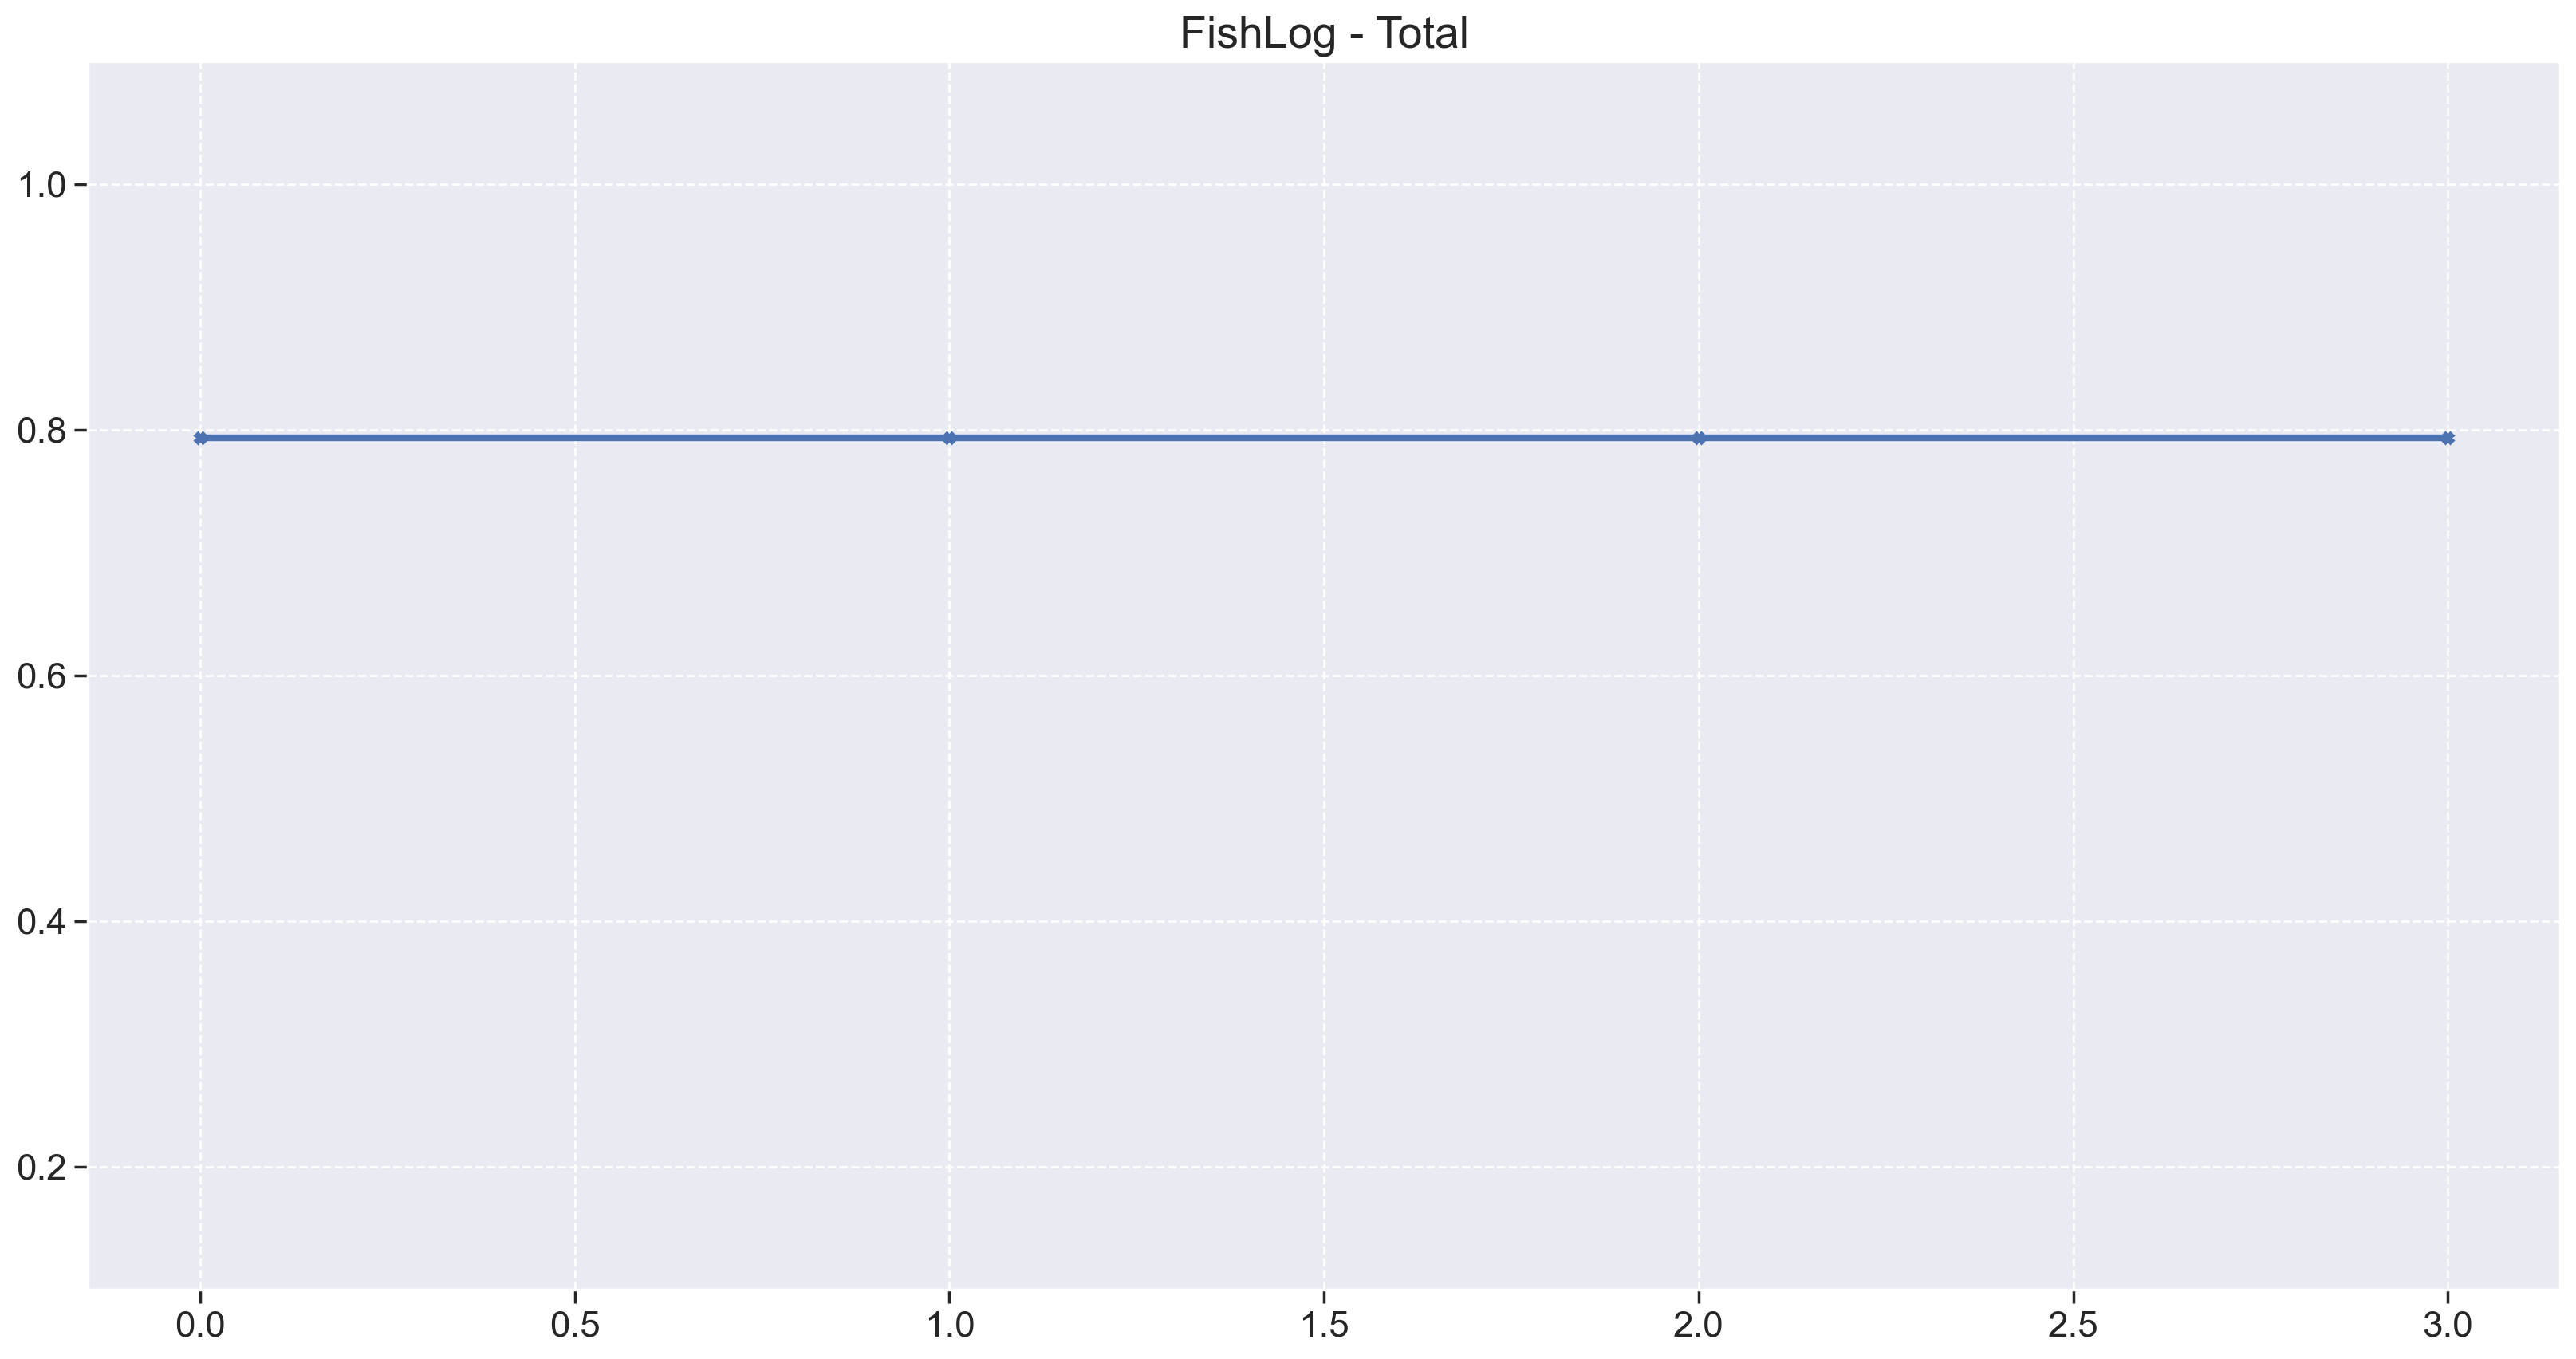

Maintainability Stats
    mean     mode   median      std      var      min      max
0.294054 0.294643 0.294643 0.001021 0.000001 0.292875 0.294643
Reliability Stats
    mean     mode   median      std          var    min      max
0.237897 0.238095 0.238095 0.000344 1.181028e-07 0.2375 0.238095


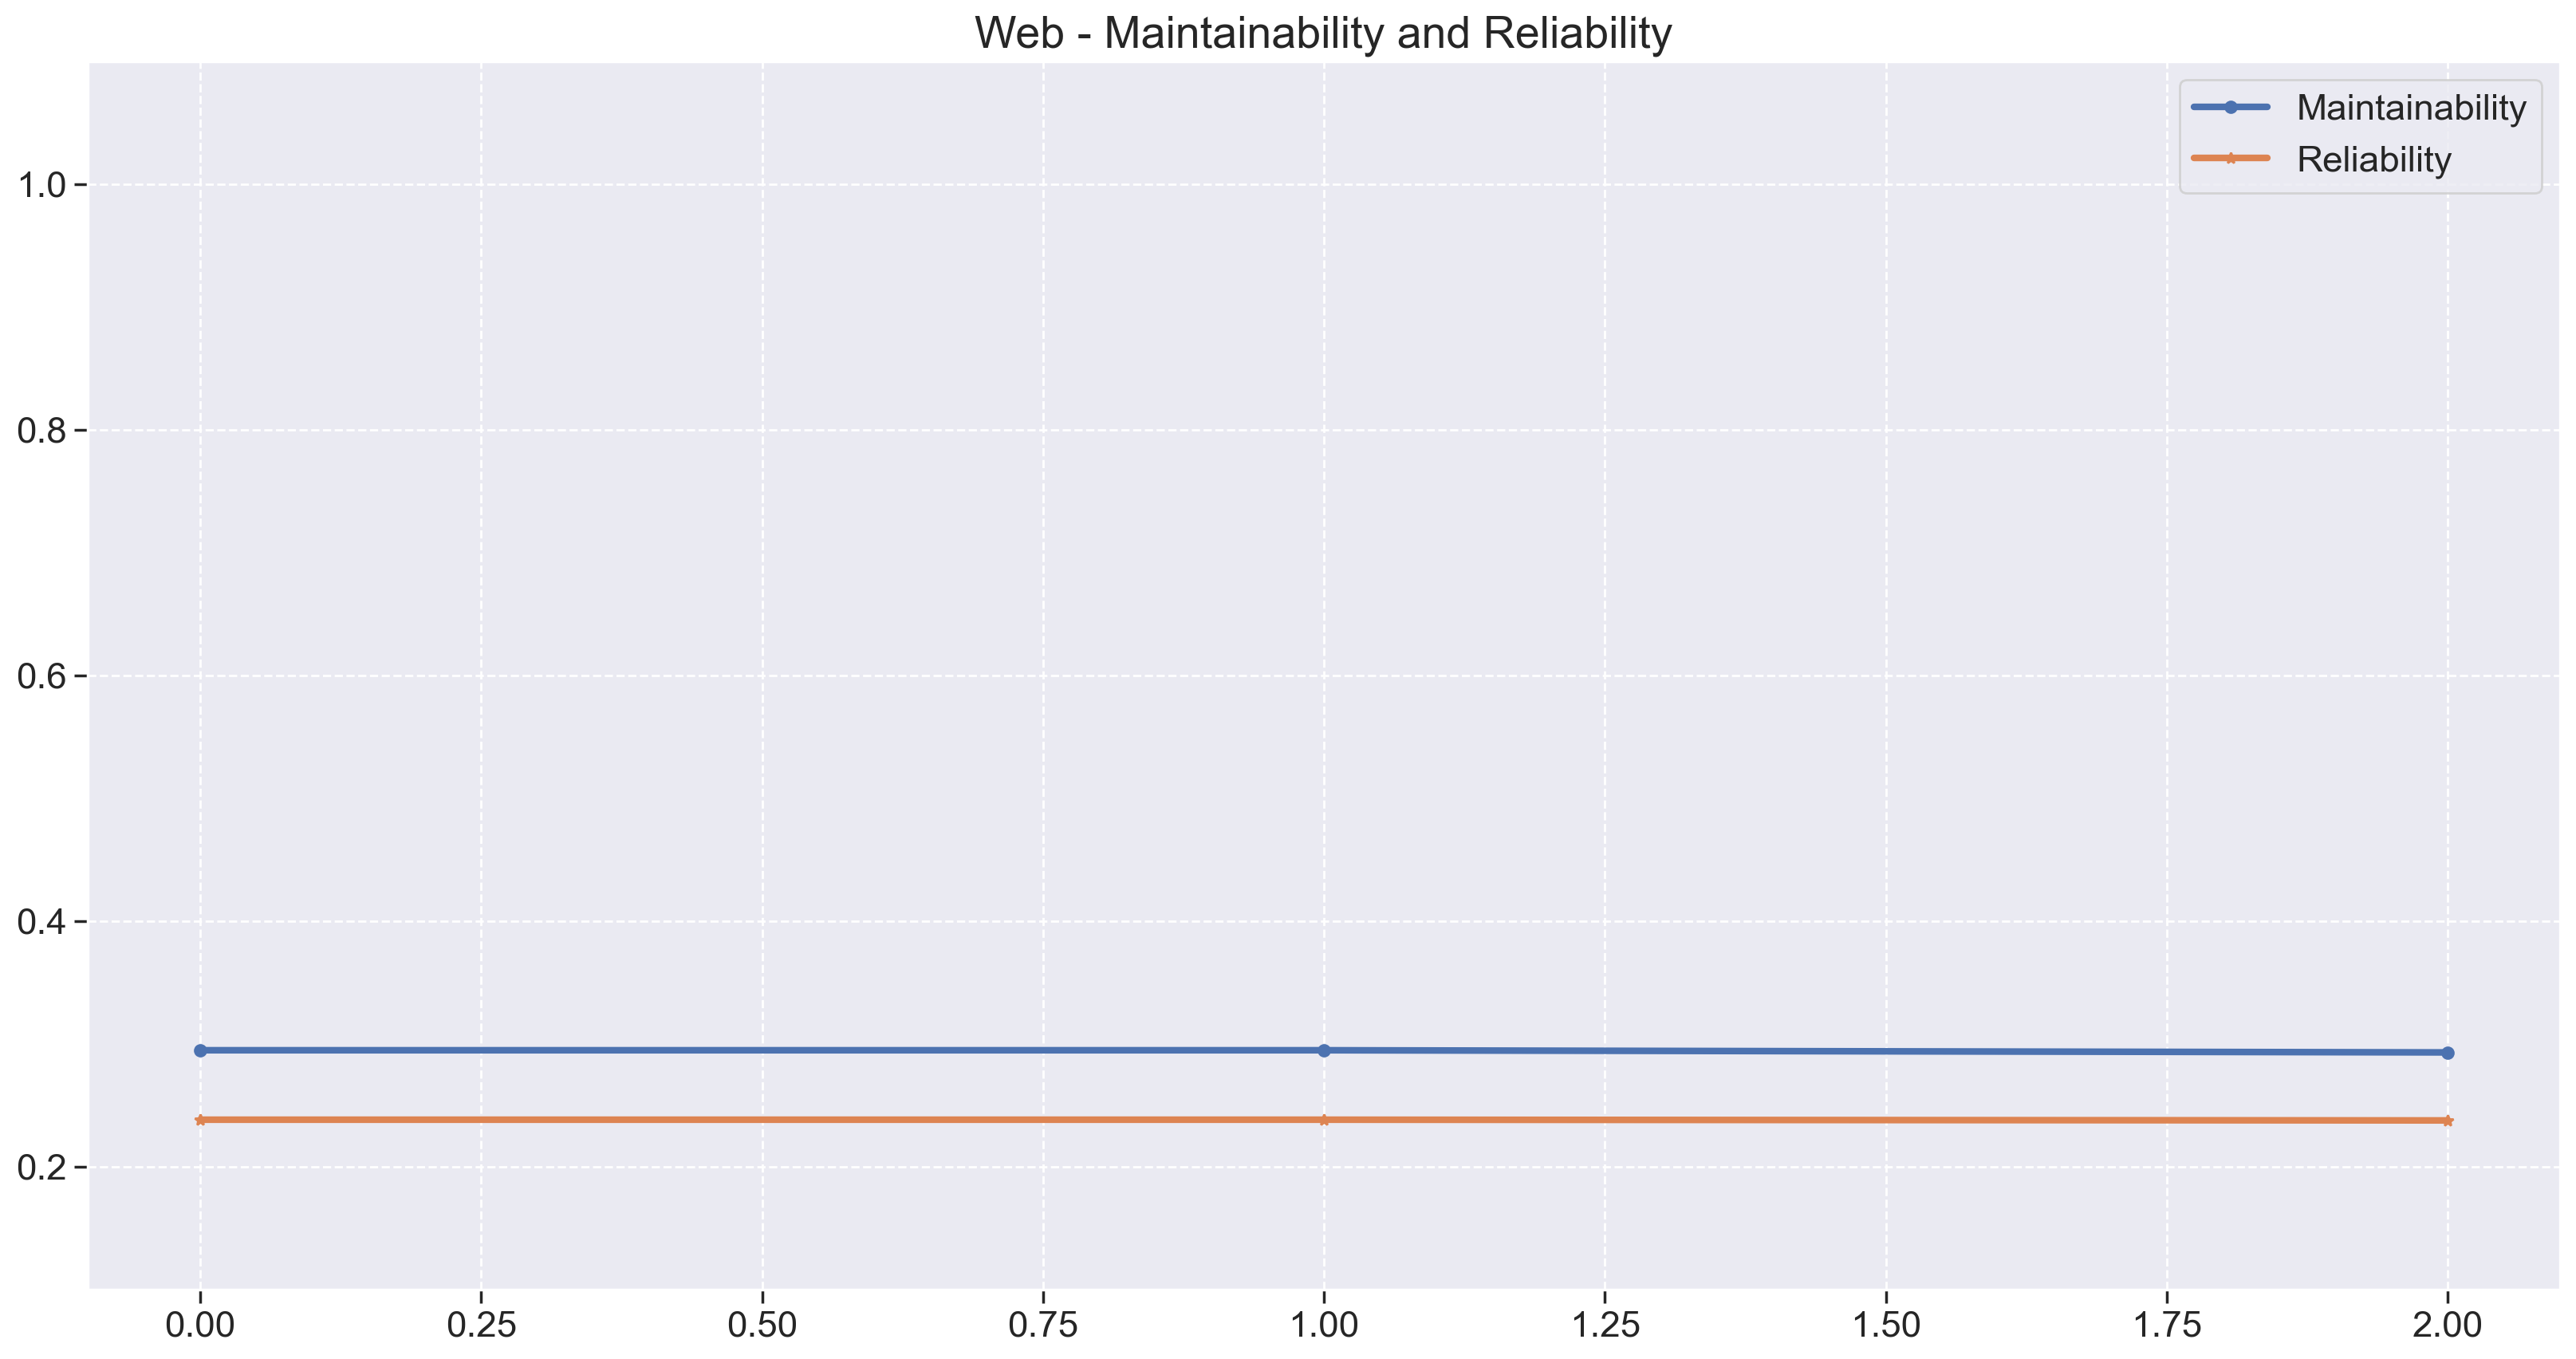

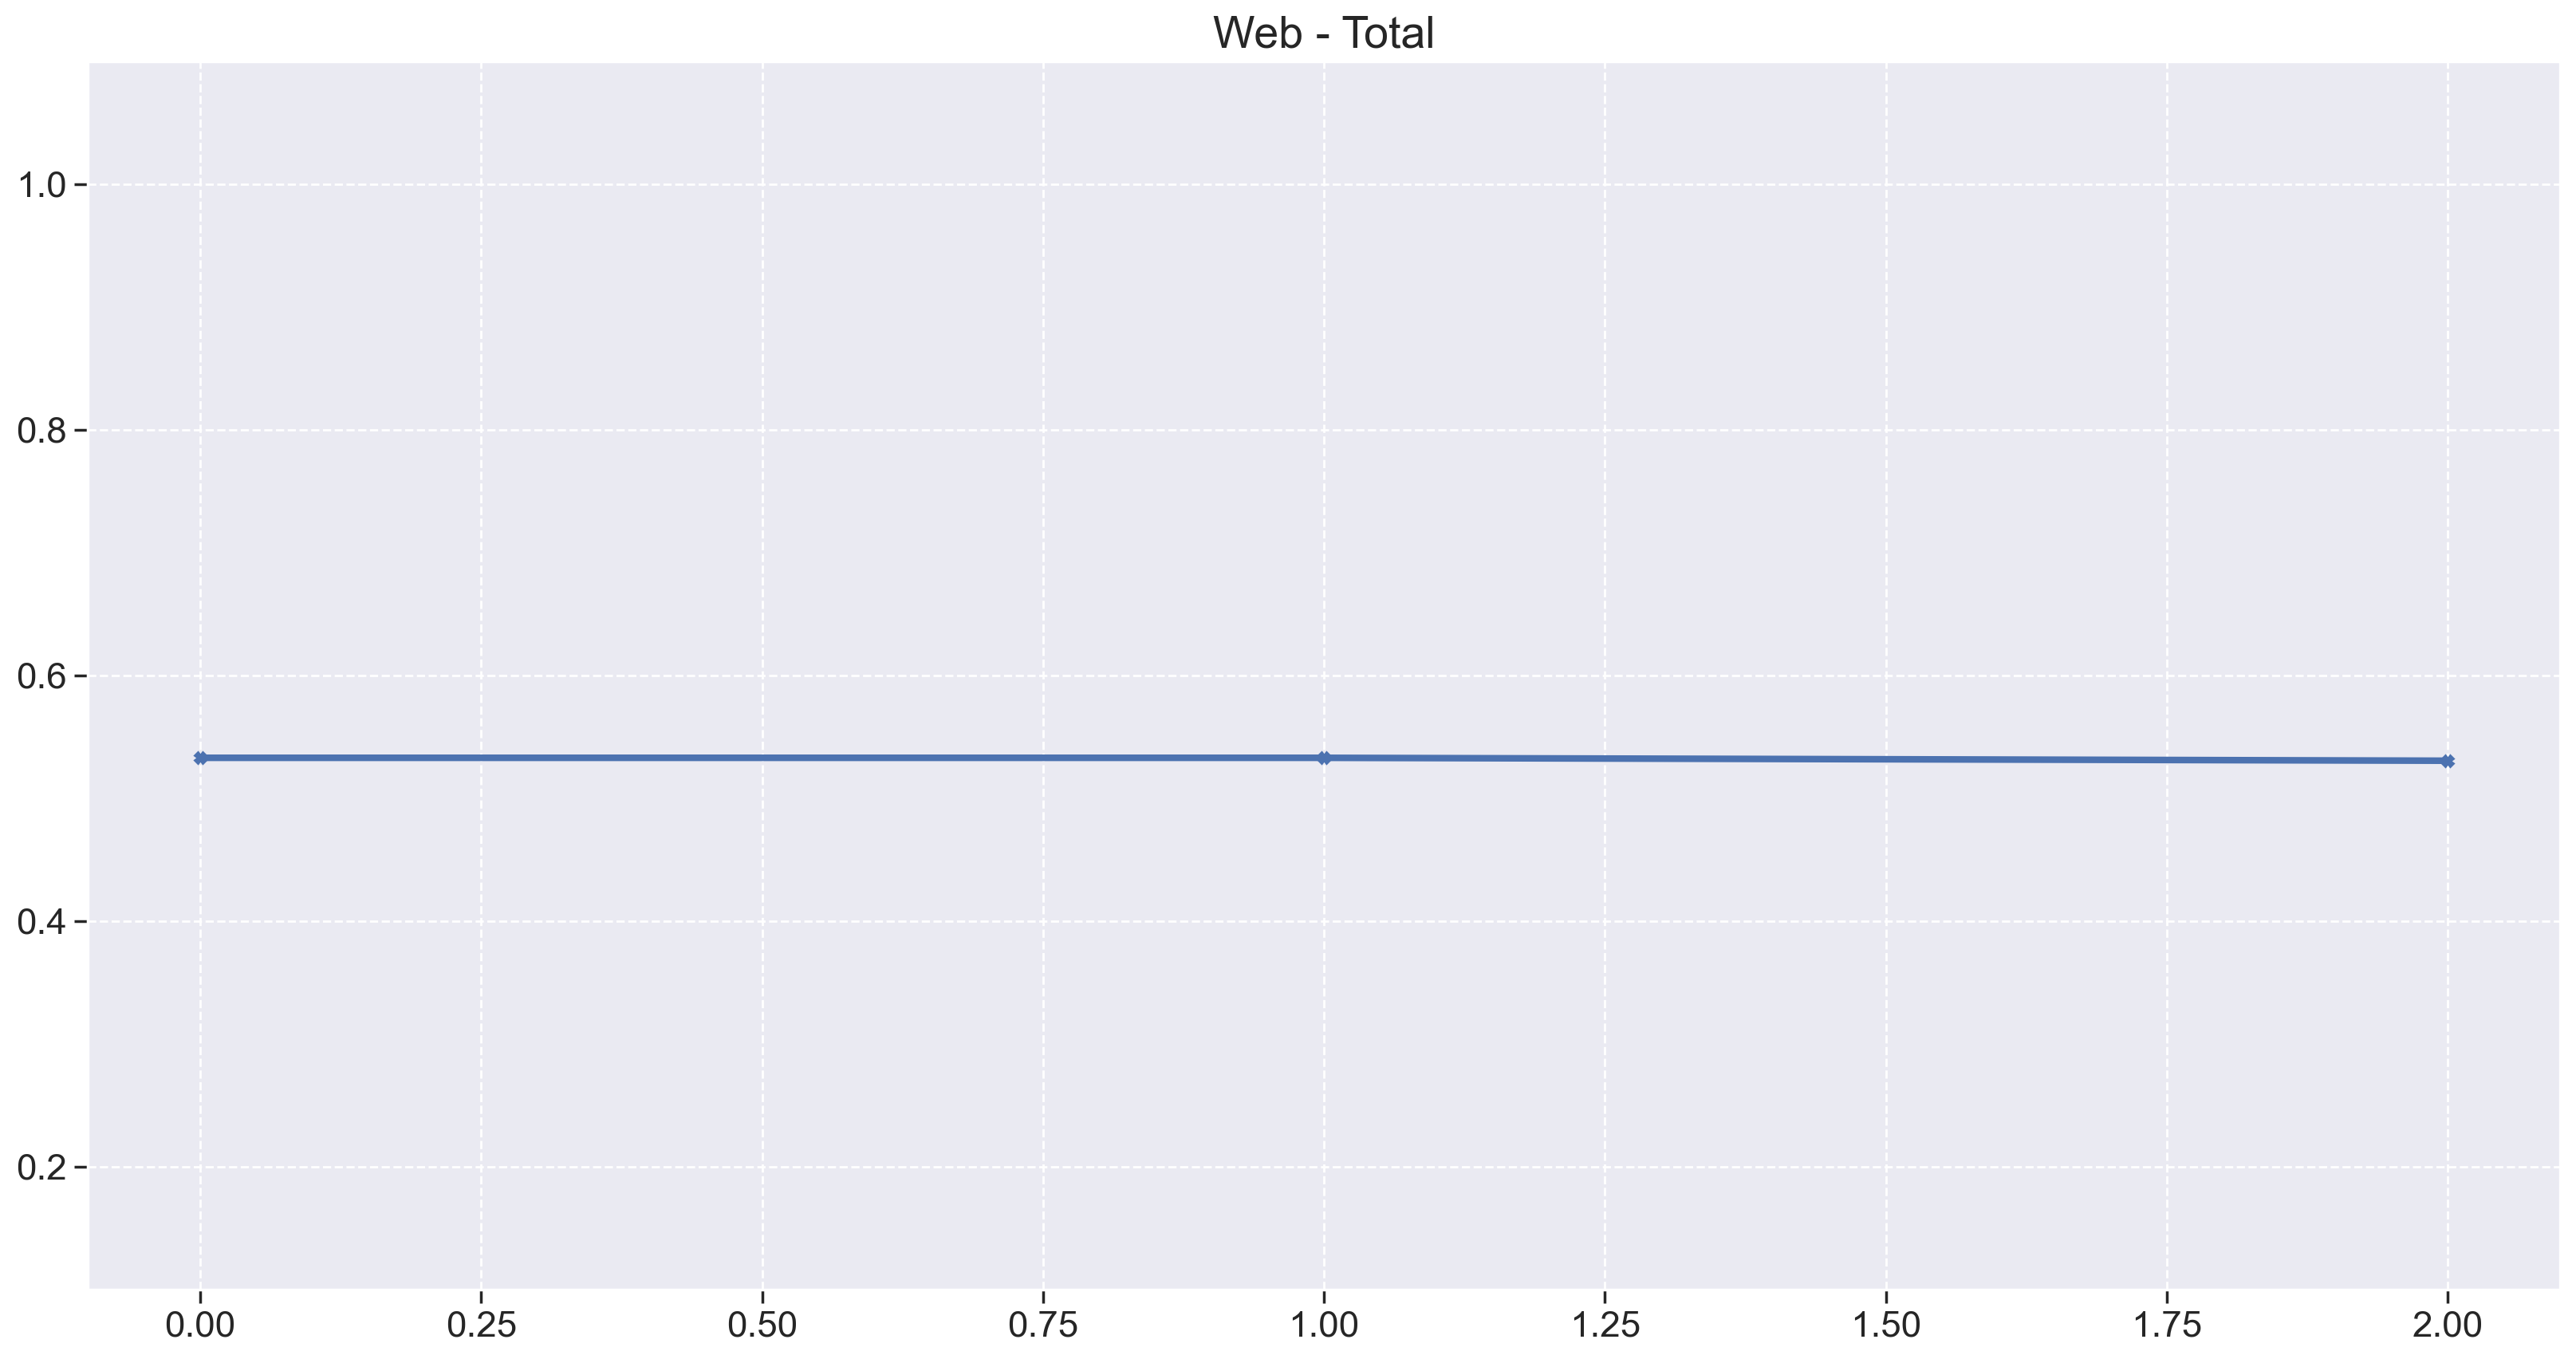

Maintainability Stats
 mean  mode  median  std  var  min  max
  0.0   0.0     0.0  0.0  0.0  0.0  0.0
Reliability Stats
 mean  mode  median  std  var  min  max
  0.0   0.0     0.0  0.0  0.0  0.0  0.0


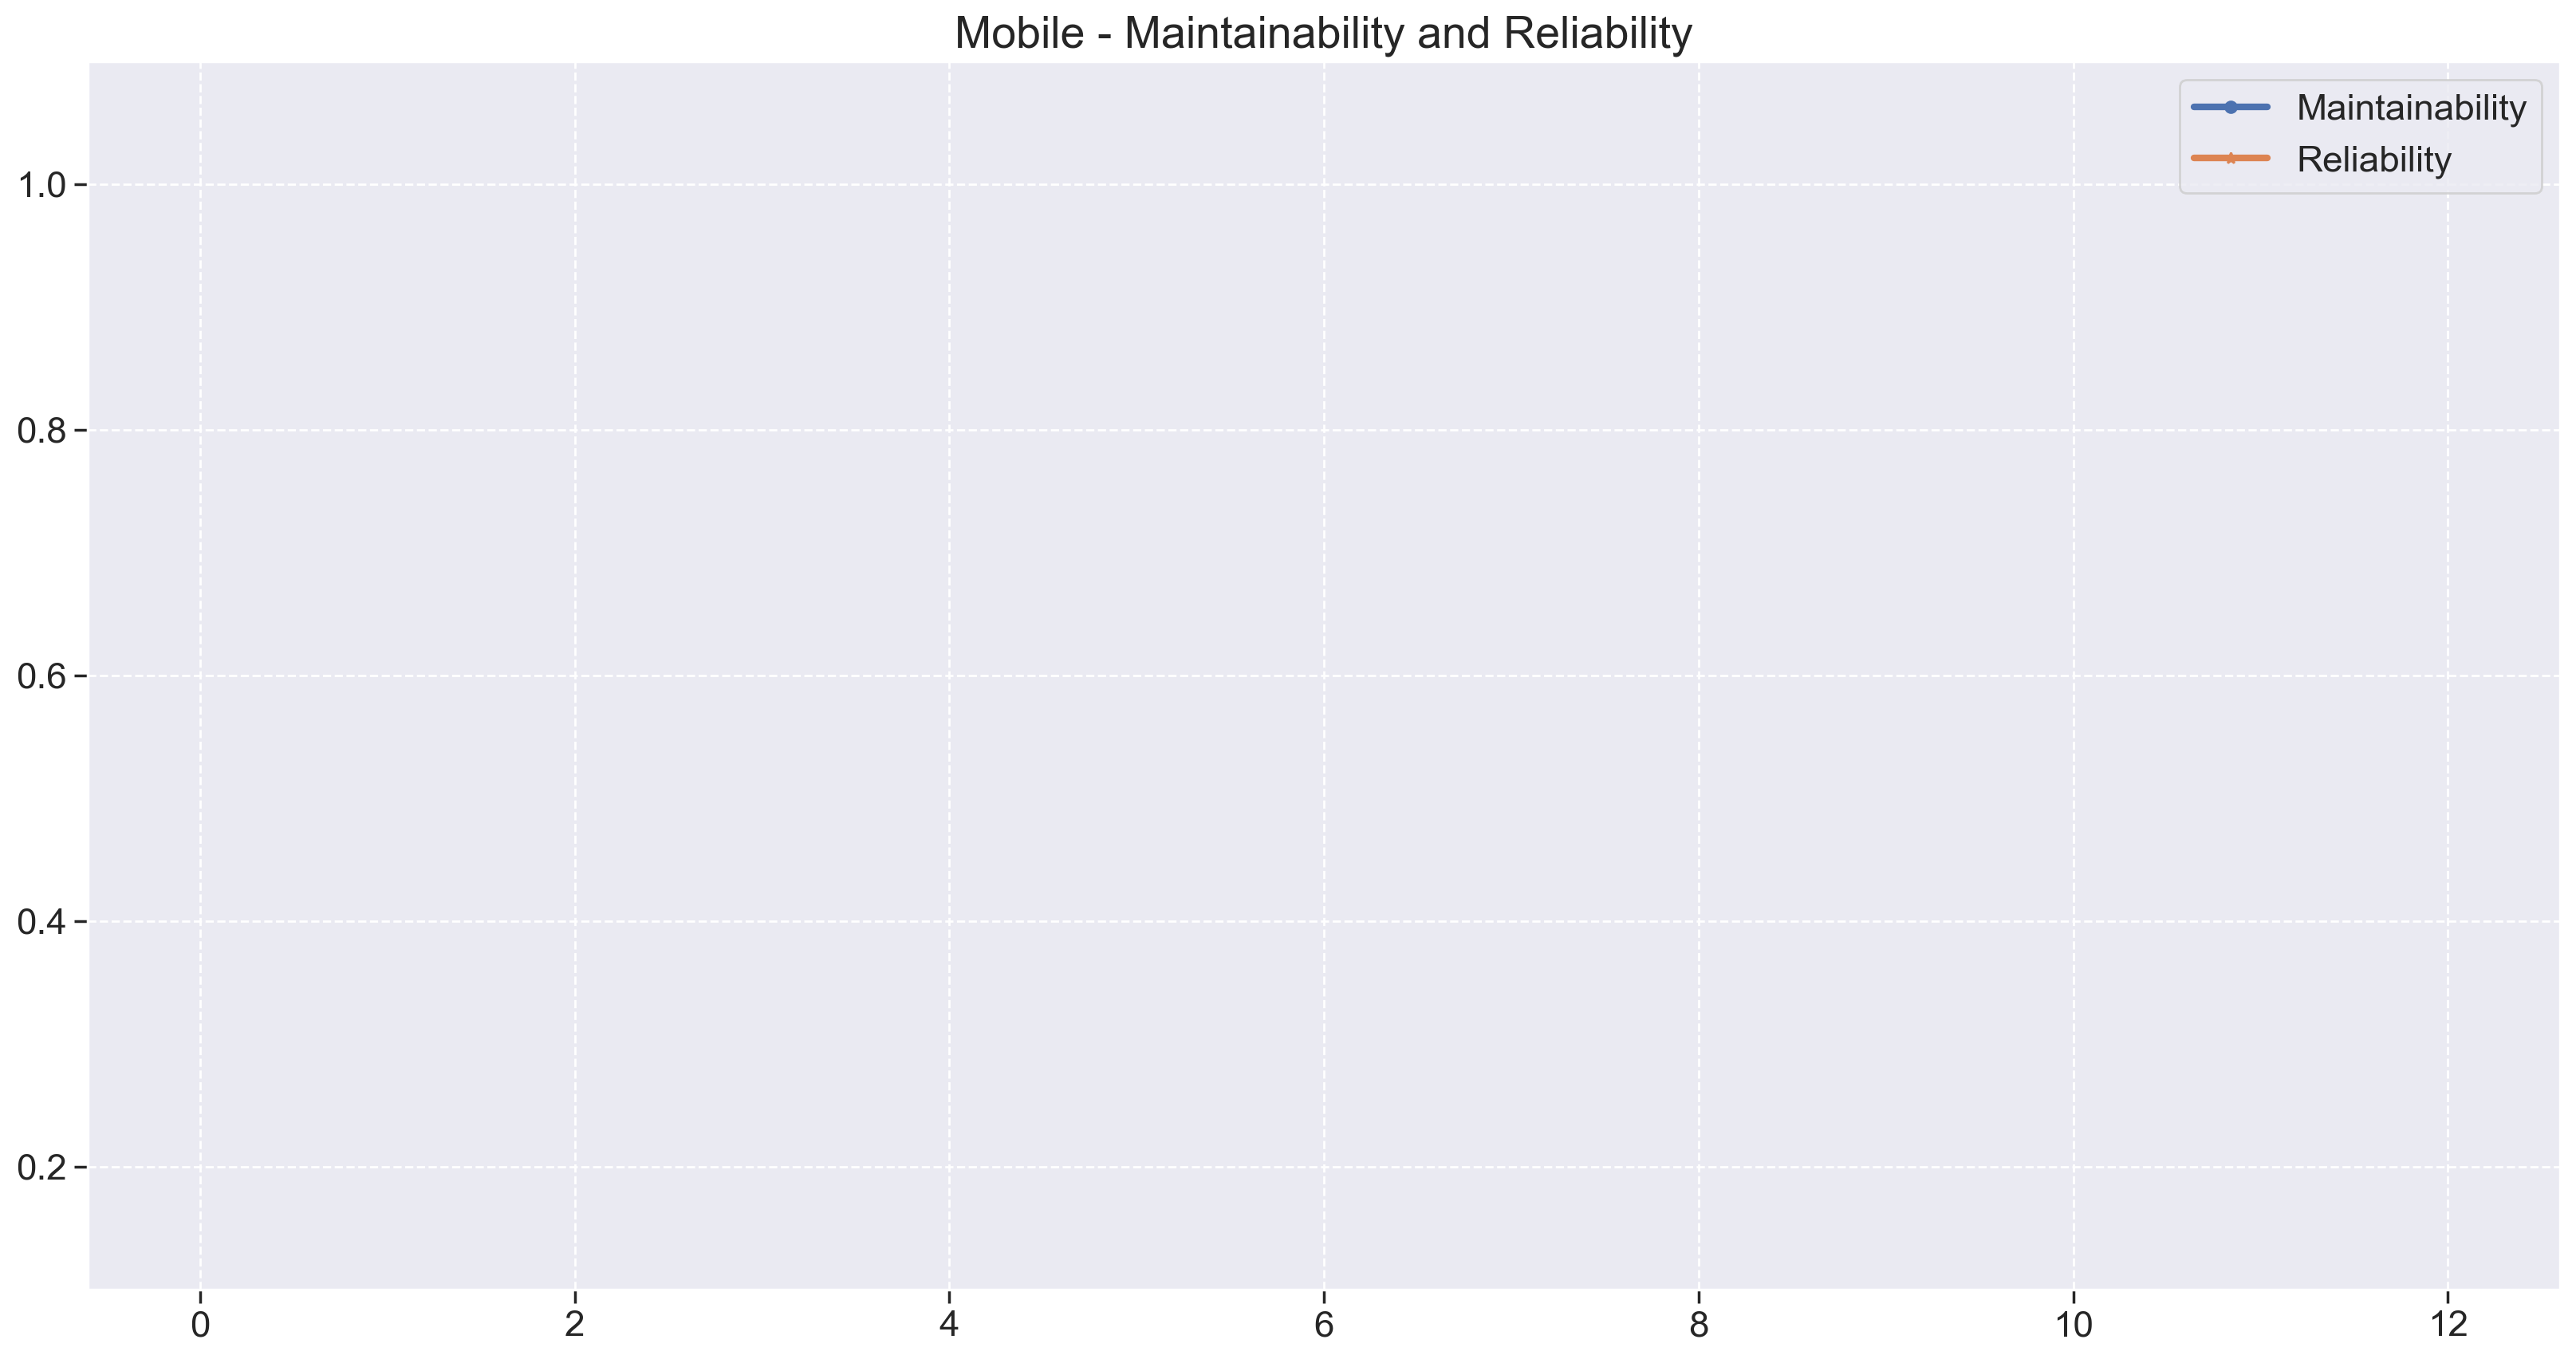

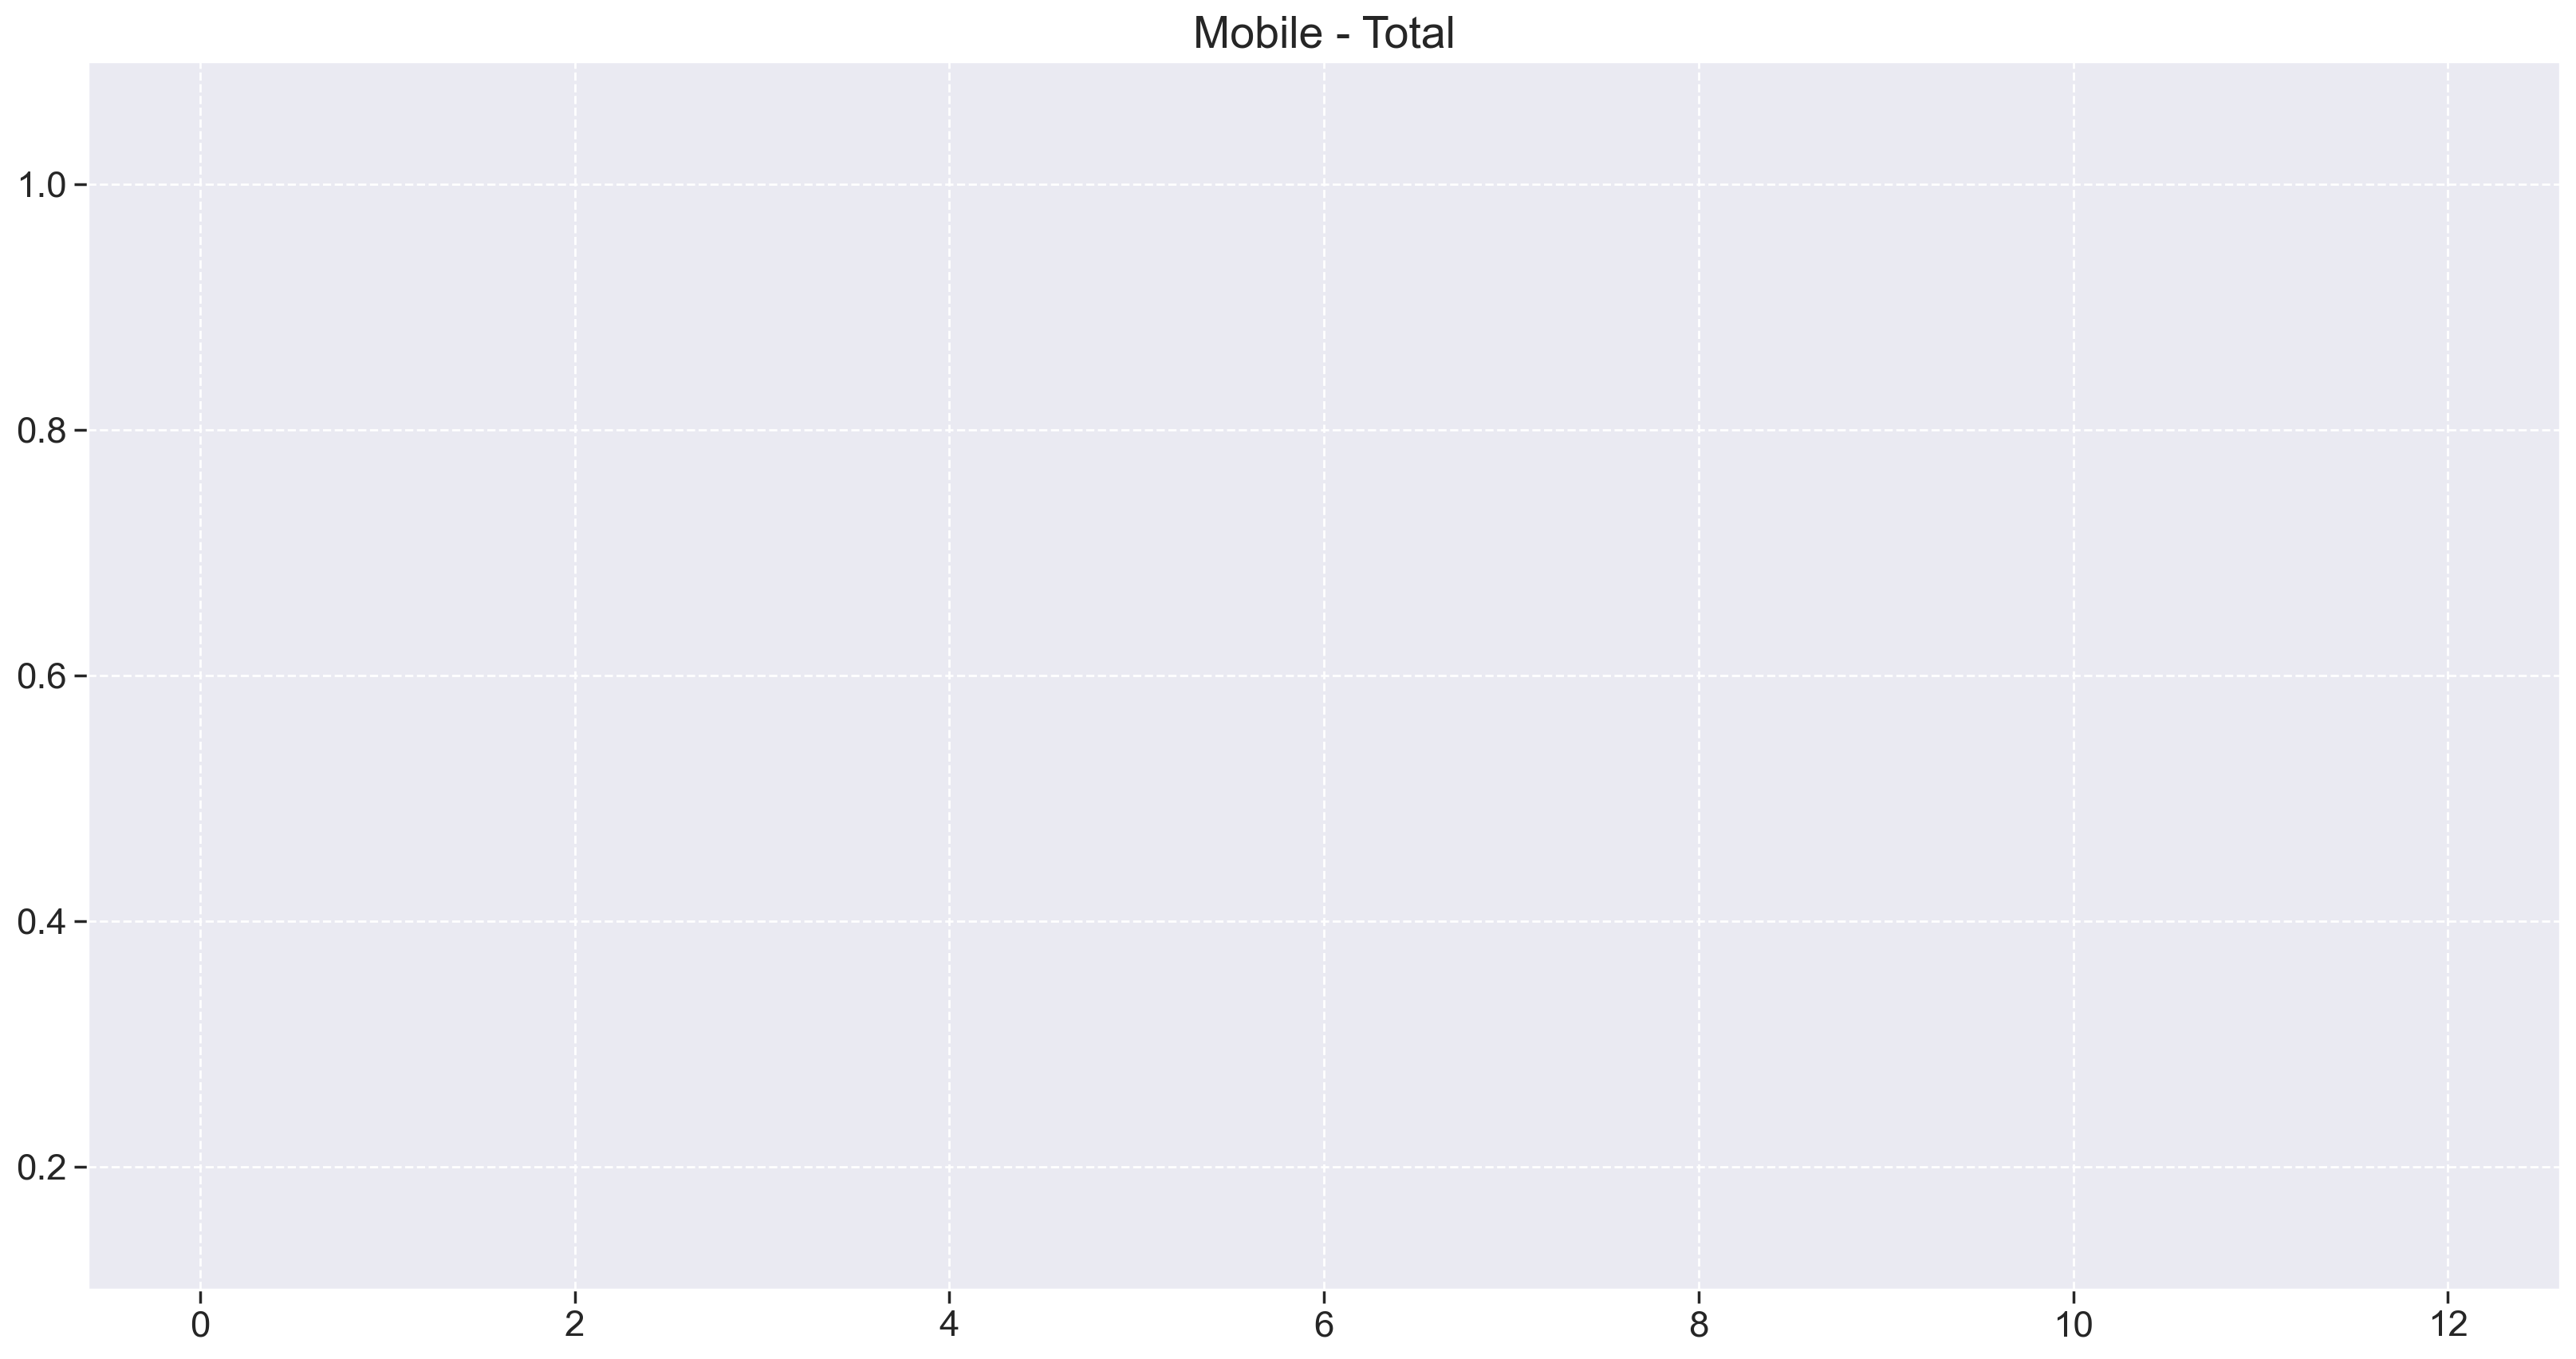

In [30]:
for name, data in metrics.items():
    analysis(data, name)

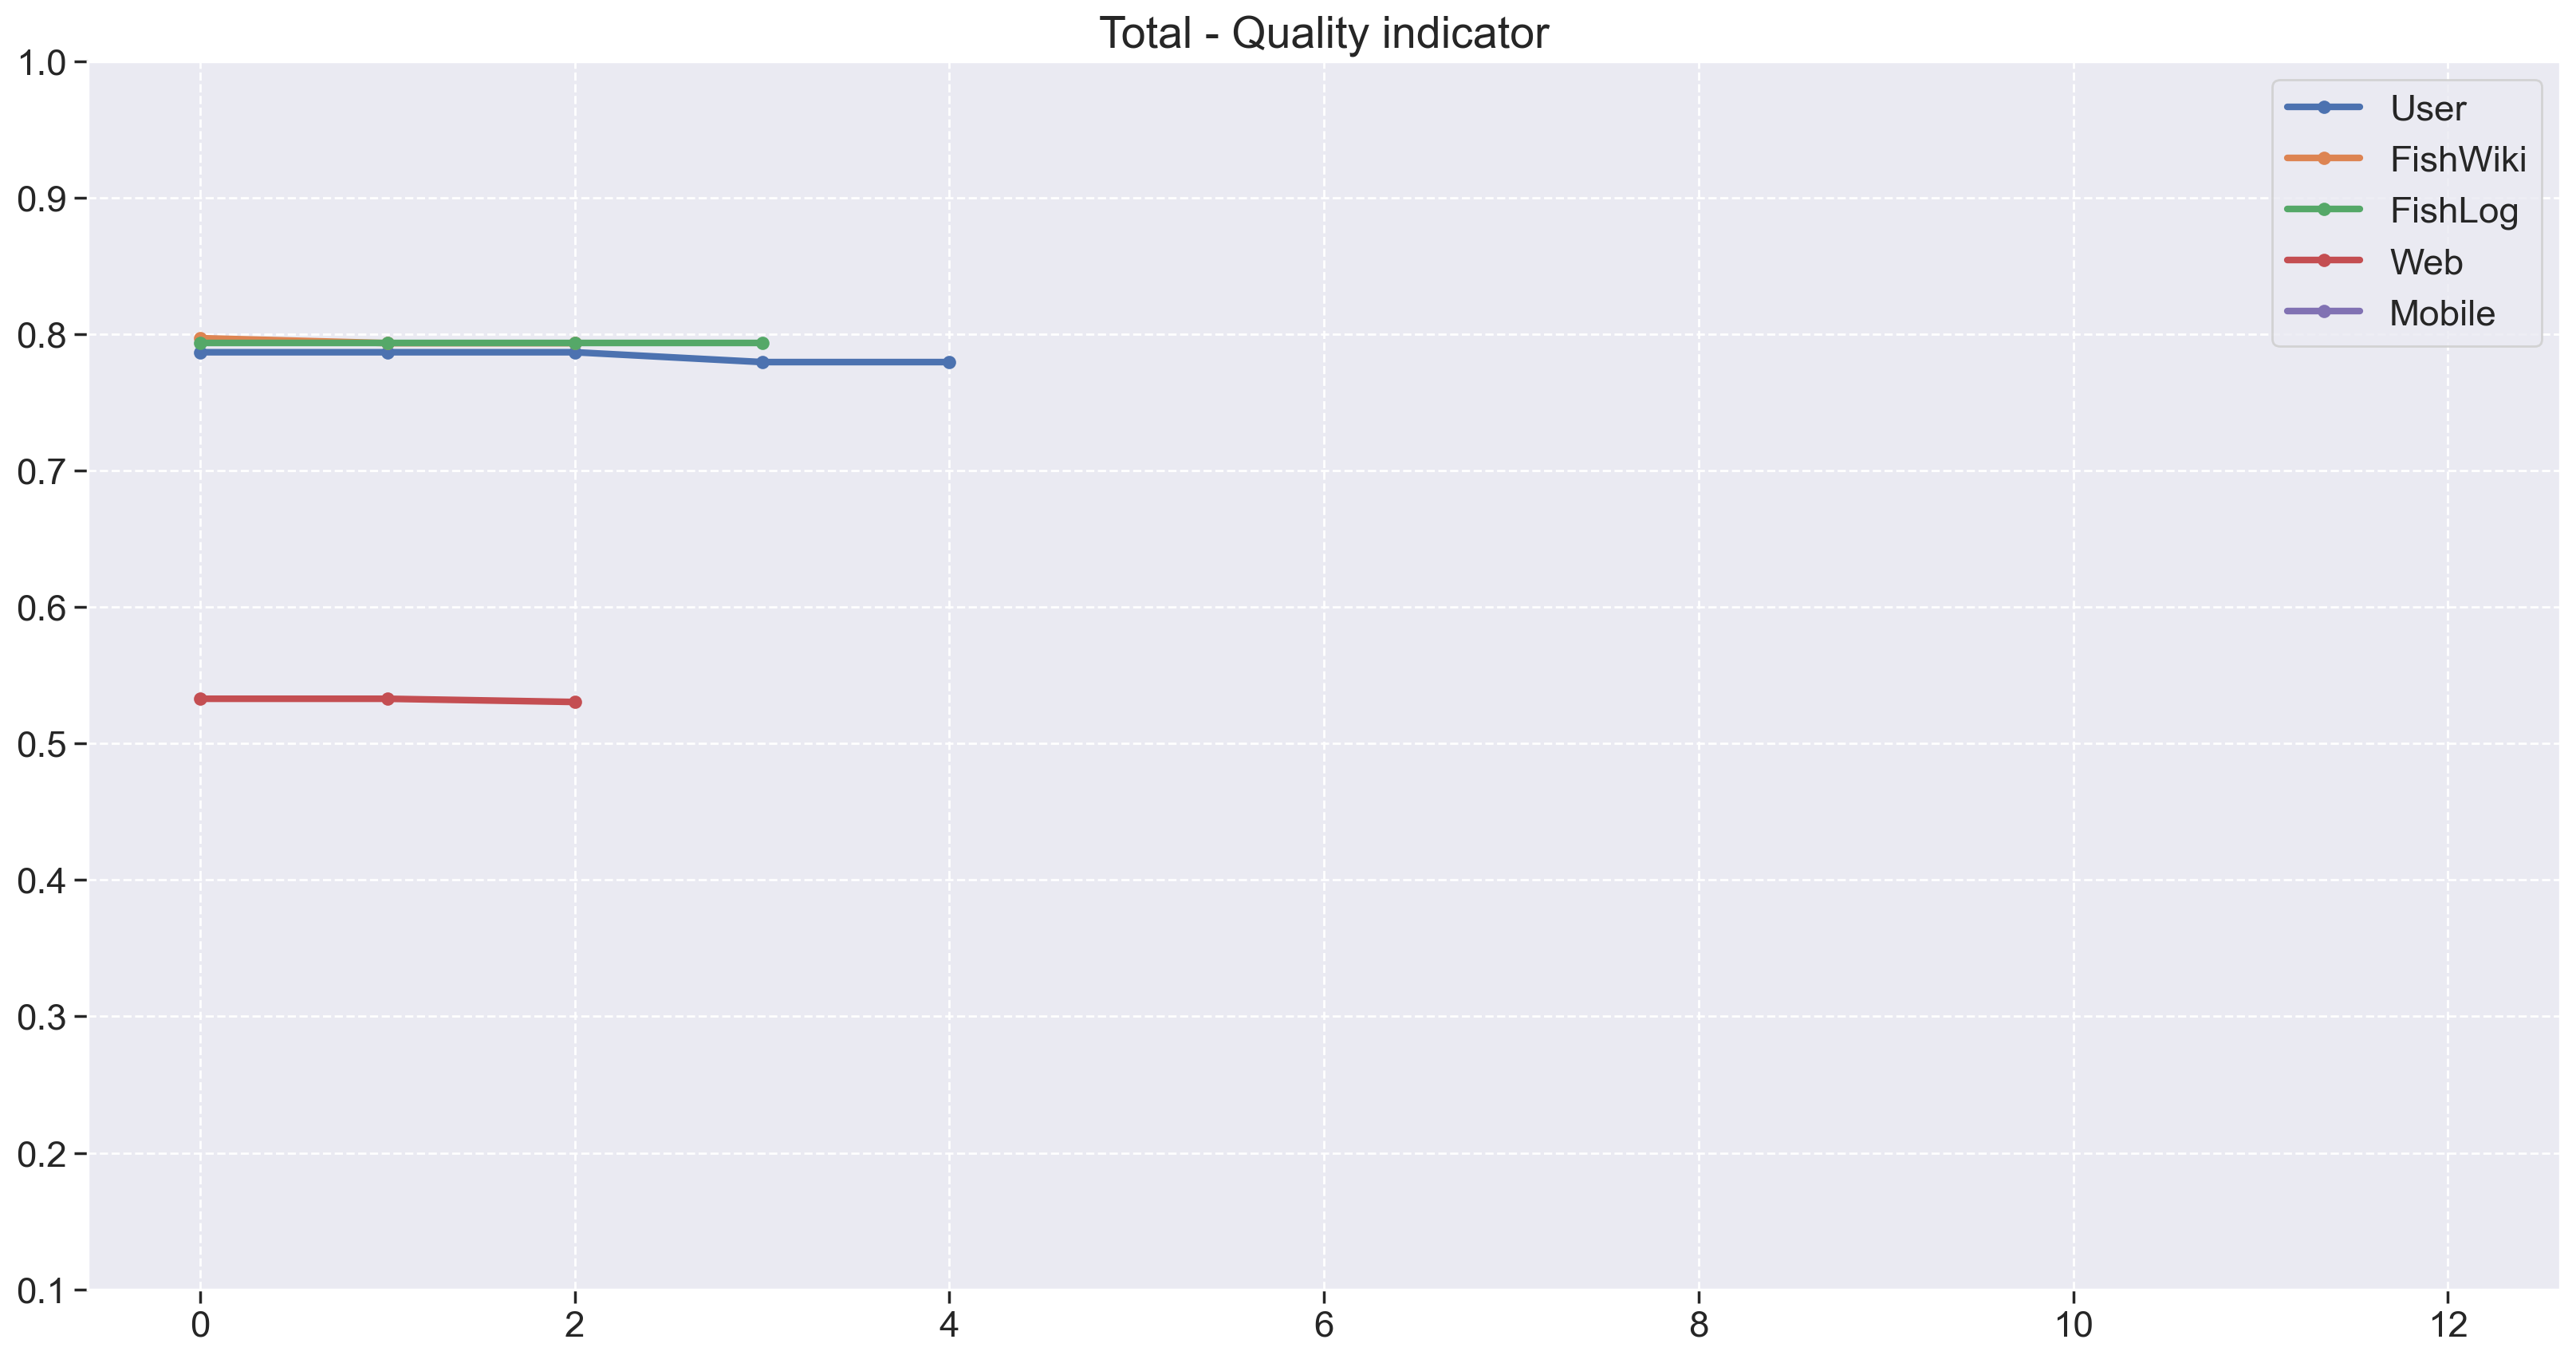

In [31]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=5, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

In [32]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

In [33]:
# Just to print in a format that is easier to read

metrics_show = metrics_df.copy()

metrics_show['repository'] = metrics_show['repository'].str.split('-').str[-1]

display(metrics_show)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./fga-eps-mds-2022-2-Eu-Pescador--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./fga-eps-mds-2022-2-Eu-Pescador--{}.csv'.format(current_datetime), index = False)

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.857143,0.000000,0.952381,1.0,1.0,0.952381,User,01-18-2023-20-35-44,2451,0.597143,0.976190,0.298571,0.488095,0.786667
1,0.857143,0.000000,0.952381,1.0,1.0,0.952381,User,01-18-2023-20-36-52,2451,0.597143,0.976190,0.298571,0.488095,0.786667
2,0.857143,0.000000,0.952381,1.0,1.0,0.952381,User,01-19-2023-15-50-38,2257,0.597143,0.976190,0.298571,0.488095,0.786667
3,0.833333,0.000000,0.944444,1.0,1.0,0.944444,User,12-12-2022-19-59-22,2045,0.586667,0.972222,0.293333,0.486111,0.779444
4,0.833333,0.000000,0.944444,1.0,1.0,0.944444,User,12-12-2022-23-30-41,2030,0.586667,0.972222,0.293333,0.486111,0.779444
5,0.700000,0.100000,1.000000,1.0,1.0,1.000000,FishWiki,01-18-2023-23-02-06,1479,0.594000,1.000000,0.297000,0.500000,0.797000
6,0.666667,0.111111,1.000000,1.0,1.0,1.000000,FishWiki,12-12-2022-20-45-58,1047,0.586667,1.000000,0.293333,0.500000,0.793333
7,0.666667,0.111111,1.000000,1.0,1.0,1.000000,FishWiki,12-12-2022-23-31-02,1047,0.586667,1.000000,0.293333,0.500000,0.793333
8,0.666667,0.111111,1.000000,1.0,1.0,1.000000,FishLog,01-18-2023-23-00-56,1145,0.586667,1.000000,0.293333,0.500000,0.793333
9,0.666667,0.111111,1.000000,1.0,1.0,1.000000,FishLog,01-19-2023-16-02-28,1145,0.586667,1.000000,0.293333,0.500000,0.793333
